# Goals
This project focuses on four transportation modes: metro, RER, train, tramway.

For the project we need 3 main things:

* A database of all stops for each line. We only consider lines for the four aforementioned transporation modes. The database should include: ID, name, position, associated line.
* A database of all lines for the four aforementioned transporation modes. The database should include: ID, name, color in the network map, company, pictogram, geospatial data. The geospatial data should be a contiguous MultiLine. An analysis of the raw data showed that each line graph is not exactly connected, which is a problem.
* Shortest paths for each pair of stops belonging to the same line. This shortest path database will help building the exact path of a route (a route being an ordered sequence of stops).

# Download data from IDFM
We use [PRIM](https://prim.iledefrance-mobilites.fr) data. PRIM is the data hub for IDFM (Ile-de-France mobilité), the administration in charge of public transportation in Paris region.

### Stops and associated lines
This dataset lists all the lines in the Ile-de-France network and the stops served for each of these lines as in GTFS.

Found here: https://prim.iledefrance-mobilites.fr/en/jeux-de-donnees/arrets-lignes?staticDataSlug=arrets-lignes

### Alignments of the Ile-de-France rail network
This dataset is a geographical represenation of the rail network (metro, RER, trains, tramway, etc).

In [46]:
RAW_DATA_PATH="raw_data"

# Data on stops
STOPS_DATA_URL="https://data.iledefrance-mobilites.fr/explore/dataset/arrets-lignes/download/\?format=json"
STOPS_DATA_FILE_PATH="raw_data/stops.json"

# Data on network (GeoJSON routes)
NETWORK_DATA_URL="https://data.iledefrance-mobilites.fr/explore/dataset/traces-du-reseau-ferre-idf/download/\?format=json"
NETWORK_DATA_FILE_PATH="raw_data/network.json"


In [47]:
# Download data
!mkdir -p $RAW_DATA_PATH
!wget $STOPS_DATA_URL -O $STOPS_DATA_FILE_PATH
!wget $NETWORK_DATA_URL -O $NETWORK_DATA_FILE_PATH

--2023-12-28 23:11:14--  https://data.iledefrance-mobilites.fr/explore/dataset/arrets-lignes/download/?format=json
Resolving data.iledefrance-mobilites.fr (data.iledefrance-mobilites.fr)... 34.249.199.226, 34.248.20.69
Connecting to data.iledefrance-mobilites.fr (data.iledefrance-mobilites.fr)|34.249.199.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘raw_data/stops.json’

raw_data/stops.json     [        <=>         ]  61,37M  4,11MB/s    in 14s     

2023-12-28 23:11:28 (4,36 MB/s) - ‘raw_data/stops.json’ saved [64355176]

--2023-12-28 23:11:29--  https://data.iledefrance-mobilites.fr/explore/dataset/traces-du-reseau-ferre-idf/download/?format=json
Resolving data.iledefrance-mobilites.fr (data.iledefrance-mobilites.fr)... 34.248.20.69, 34.249.199.226
Connecting to data.iledefrance-mobilites.fr (data.iledefrance-mobilites.fr)|34.248.20.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: u

# Load data

In [48]:
import geopandas as gpd
import pandas as pd
import json
from shapely import LineString, Point, MultiPoint

### Network

In [49]:
# Load network json data into a Pandas dataframe
with open(NETWORK_DATA_FILE_PATH, 'r') as data:
    network = pd.json_normalize(json.load(data))
network.head()

,datasetid,recordid,record_timestamp,fields.geo_point_2d,fields.shape_leng,fields.reseau,fields.picto_final,fields.idrefliga,fields.colourweb_hexa,fields.mode,...,fields.train,fields.tramway,fields.indice_lig,fields.val,fields.extcode,fields.metro,fields.exploitant,fields.date_mes,geometry.type,geometry.coordinates
0,traces-du-reseau-ferre-idf,ab5cf61b212d033315c862b98c70d6fadd65d59b,2023-12-06T15:35:03.253Z,"[48.89343780342383, 2.4849705516729346]",438.626918,TRAMWAY,https://data.iledefrance-mobilites.fr/explore/...,A01761,dfaf47,TRAMWAY,...,0,1,4,0,800:T4,0,SNCF,2006-11-20T00:00:00Z,Point,"[2.4849705516729346, 48.89343780342383]"
1,traces-du-reseau-ferre-idf,ada7234fa14e174322d0bf3e40918c9563fc5117,2023-12-06T15:35:03.253Z,"[48.64144963803747, 2.444004269027656]",2029.886681,RER D,https://data.iledefrance-mobilites.fr/explore/...,A01842,008b5b,RER,...,0,0,D,0,800:D,0,SNCF,1995-09-24T00:00:00Z,Point,"[2.444004269027656, 48.64144963803747]"
2,traces-du-reseau-ferre-idf,8cab5aae2c1a34085ef1af5a446aef12fb5e9509,2023-12-06T15:35:03.253Z,"[48.65419193389779, 2.425509025813071]",1894.845263,RER D,https://data.iledefrance-mobilites.fr/explore/...,A01842,008b5b,RER,...,0,0,D,0,800:D,0,SNCF,1995-09-24T00:00:00Z,Point,"[2.425509025813071, 48.65419193389779]"
3,traces-du-reseau-ferre-idf,393927eaf13eef99d4efe8ea52561c6a880134b0,2023-12-06T15:35:03.253Z,"[48.83555894233859, 2.2225906308238206]",1658.124659,TRAMWAY,https://data.iledefrance-mobilites.fr/explore/...,A01192,cf009e,TRAMWAY,...,0,1,2,0,100112012:T2,0,RATP,1997-07-02T00:00:00Z,Point,"[2.2225906308238206, 48.83555894233859]"
4,traces-du-reseau-ferre-idf,56d1c4e6f05d4650eed6278145c12d4ac10f5365,2023-12-06T15:35:03.253Z,"[48.72106384794022, 2.252748930215579]",1447.235934,RER B,https://data.iledefrance-mobilites.fr/explore/...,A01857,5091cb,RER,...,0,0,B,0,810:B,0,RATP,1854-07-28T00:00:00Z,Point,"[2.252748930215579, 48.72106384794022]"


In [50]:
# Select relevant fields
network_relevant_fields = {
    "fields.idrefligc": 'short_id',
    "fields.geo_shape.coordinates": 'geometry',
    "fields.res_com": 'name',
    "fields.exploitant": 'company',
    "fields.mode": 'transportation_type',
    "fields.colourweb_hexa": 'color',
    "fields.idf": 'in_idf',
    "fields.picto_final": 'picture_url'
}
network = network[list(network_relevant_fields.keys())]
network = network.rename(columns=network_relevant_fields)

network['short_id'] = network['short_id'].astype('string')
network['name'] = network['name'].astype('string')
network['company'] = network['company'].astype('string')
network['transportation_type'] = network['transportation_type'].astype('string')
network['color'] = network['color'].astype('string')
network['in_idf'] = network['in_idf'].astype('bool')
network['picture_url'] = network['picture_url'].astype('string')

network.head()

,short_id,geometry,name,company,transportation_type,color,in_idf,picture_url
0,C01843,"[[2.482032922407471, 48.893805859684164], [2.4...",TRAM 4,SNCF,TRAMWAY,dfaf47,True,https://data.iledefrance-mobilites.fr/explore/...
1,C01728,"[[2.452573392272449, 48.63426831143351], [2.45...",RER D,SNCF,RER,008b5b,True,https://data.iledefrance-mobilites.fr/explore/...
2,C01728,"[[2.435330530181304, 48.64848911165158], [2.43...",RER D,SNCF,RER,008b5b,True,https://data.iledefrance-mobilites.fr/explore/...
3,C01390,"[[2.22531285326707, 48.82901050275979], [2.225...",TRAM 2,RATP,TRAMWAY,cf009e,True,https://data.iledefrance-mobilites.fr/explore/...
4,C01743,"[[2.245672514581905, 48.716946286650035], [2.2...",RER B,RATP,RER,5091cb,True,https://data.iledefrance-mobilites.fr/explore/...


In [51]:
# Only keep select transportation modes
network = network[network.transportation_type.isin(['TRAMWAY', 'RER', 'METRO', 'TRAIN'])]

# Filter out row with missing data
network = network[network.color.notna()]

In [52]:
# Convert to GeoDataFrame
network.geometry = network.geometry.apply(lambda x: LineString(x))
network = gpd.GeoDataFrame(network, geometry='geometry')
network

,short_id,geometry,name,company,transportation_type,color,in_idf,picture_url
0,C01843,"LINESTRING (2.48203 48.89381, 2.48369 48.89357...",TRAM 4,SNCF,TRAMWAY,dfaf47,True,https://data.iledefrance-mobilites.fr/explore/...
1,C01728,"LINESTRING (2.45257 48.63427, 2.45168 48.63494...",RER D,SNCF,RER,008b5b,True,https://data.iledefrance-mobilites.fr/explore/...
2,C01728,"LINESTRING (2.43533 48.64849, 2.43430 48.64919...",RER D,SNCF,RER,008b5b,True,https://data.iledefrance-mobilites.fr/explore/...
3,C01390,"LINESTRING (2.22531 48.82901, 2.22524 48.82939...",TRAM 2,RATP,TRAMWAY,cf009e,True,https://data.iledefrance-mobilites.fr/explore/...
4,C01743,"LINESTRING (2.24567 48.71695, 2.24603 48.71739...",RER B,RATP,RER,5091cb,True,https://data.iledefrance-mobilites.fr/explore/...
...,...,...,...,...,...,...,...,...
1638,C02528,"LINESTRING (2.27275 48.76379, 2.26747 48.76450...",TRAM 10,RD Bièvre,TRAMWAY,6e6e00,True,https://data.iledefrance-mobilites.fr/explore/...
1639,C02528,"LINESTRING (2.25317 48.78721, 2.25295 48.78826...",TRAM 10,RD Bièvre,TRAMWAY,6e6e00,True,https://data.iledefrance-mobilites.fr/explore/...
1640,C02529,"LINESTRING (2.35474 48.66789, 2.35571 48.66771...",TRAM 12,SNCF,TRAMWAY,a50034,True,https://data.iledefrance-mobilites.fr/explore/...
1641,C02529,"LINESTRING (2.38340 48.65213, 2.38591 48.64953...",TRAM 12,SNCF,TRAMWAY,a50034,True,https://data.iledefrance-mobilites.fr/explore/...


In [53]:
network.info(memory_usage="deep")

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1230 entries, 0 to 1642
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   short_id             1230 non-null   string  
 1   geometry             1230 non-null   geometry
 2   name                 1230 non-null   string  
 3   company              1230 non-null   string  
 4   transportation_type  1230 non-null   string  
 5   color                1230 non-null   string  
 6   in_idf               1230 non-null   bool    
 7   picture_url          1230 non-null   string  
dtypes: bool(1), geometry(1), string(6)
memory usage: 607.7 KB


### Stops

In [54]:
# Load stops json data into a Pandas dataframe
with open(STOPS_DATA_FILE_PATH, 'r') as data:
    stops = pd.json_normalize(json.load(data))
stops.head()

,datasetid,recordid,fields.operatorname,fields.stop_id,fields.pointgeo,fields.schedules,fields.stop_name,fields.code_insee,fields.id,fields.route_long_name,fields.stop_lat,fields.nom_commune,fields.plans,fields.stop_lon,geometry.type,geometry.coordinates
0,arrets-lignes,01cc0e396e33858e93713e295f11a24e62cd0827,Francilité Pays de Montereau,IDFM:480040,"[48.38009909174341, 2.9433584694721757]","[{""routeId"": ""route:IDFM:FPM:105200-C01439-515...",Gare de Montereau Quai 1,77305,IDFM:C01439,G,48.38009909174341,Montereau-Fault-Yonne,"[{""link"": ""https://ilico.iledefrance-mobilites...",2.9433584694721757,Point,"[2.9433584694721757, 48.38009909174341]"
1,arrets-lignes,d36b722090b3ae41c33dad02af90477338e50d74,Francilité Pays de Montereau,IDFM:15777,"[48.38479845247609, 2.9057645857962866]","[{""routeId"": ""route:IDFM:FPM:105200-C01439-515...",Bas Clos,77210,IDFM:C01439,G,48.38479845247609,La Grande-Paroisse,"[{""link"": ""https://ilico.iledefrance-mobilites...",2.9057645857962866,Point,"[2.9057645857962866, 48.38479845247609]"
2,arrets-lignes,ae416472e7de5527bd2ce2a44d304ce330eff475,Francilité Pays de Montereau,IDFM:15900,"[48.38950632103082, 2.9568020961246364]","[{""routeId"": ""route:IDFM:FPM:105200-C01439-515...",Quai de Seine,77305,IDFM:C01439,G,48.38950632103082,Montereau-Fault-Yonne,"[{""link"": ""https://ilico.iledefrance-mobilites...",2.9568020961246364,Point,"[2.9568020961246364, 48.38950632103082]"
3,arrets-lignes,3705c2fcb10f5b4c9114a9e9aab64e96c6856b96,Francilité Pays de Montereau,IDFM:7164,"[48.394932006075756, 2.9587564705394156]","[{""routeId"": ""route:IDFM:FPM:105200-C01439-515...",Lycée André Malraux,77305,IDFM:C01439,G,48.394932006075756,Montereau-Fault-Yonne,"[{""link"": ""https://ilico.iledefrance-mobilites...",2.9587564705394156,Point,"[2.9587564705394156, 48.394932006075756]"
4,arrets-lignes,5ebe589ab5be79502253a29b5529a2eac9b46135,Francilité Pays de Montereau,IDFM:15916,"[48.386158645917696, 2.9543871053622546]","[{""routeId"": ""route:IDFM:FPM:105200-C01439-515...",Rustic,77305,IDFM:C01439,G,48.386158645917696,Montereau-Fault-Yonne,"[{""link"": ""https://ilico.iledefrance-mobilites...",2.9543871053622546,Point,"[2.9543871053622546, 48.386158645917696]"


In [55]:
# Select relevant fields
stops_relevant_fields = {
    "fields.stop_id": 'id',
    "fields.stop_lon": 'longitude',
    "fields.stop_lat": 'latitude',
    "fields.stop_name": 'name',
    "fields.id": 'line_id',
    "fields.operatorname": 'company',
}
stops = stops[list(stops_relevant_fields.keys())]
stops = stops.rename(columns=stops_relevant_fields)

stops['id'] = stops['id'].astype("string")
stops['name'] = stops['name'].astype("string")
stops['company'] = stops['company'].astype("string")
stops['line_id'] = stops['line_id'].astype("string")
stops['longitude'] = stops['longitude'].astype(float)
stops['latitude'] = stops['latitude'].astype(float)

stops.head()


,id,longitude,latitude,name,line_id,company
0,IDFM:480040,2.943358,48.380099,Gare de Montereau Quai 1,IDFM:C01439,Francilité Pays de Montereau
1,IDFM:15777,2.905765,48.384798,Bas Clos,IDFM:C01439,Francilité Pays de Montereau
2,IDFM:15900,2.956802,48.389506,Quai de Seine,IDFM:C01439,Francilité Pays de Montereau
3,IDFM:7164,2.958756,48.394932,Lycée André Malraux,IDFM:C01439,Francilité Pays de Montereau
4,IDFM:15916,2.954387,48.386159,Rustic,IDFM:C01439,Francilité Pays de Montereau


In [56]:
# Match line ID format with network dataframe
stops['line_short_id'] = stops['line_id'].apply(lambda x: x.split(":")[-1])
stops['line_short_id'] = stops['line_short_id'].astype("string")

In [57]:
# Remove prefix from stop ID
stops['short_id'] = stops['id'].apply(lambda x: x.split(":")[-1])
stops['short_id'] = stops['short_id'].astype("string")

In [58]:
# Only use stops of railroad network (metro, train, tramway)
stops = stops[stops.line_short_id.isin(network.short_id)]

In [59]:
# Convert stops dataframe to a geodataframe
stops = gpd.GeoDataFrame(stops, geometry=gpd.points_from_xy(stops.longitude, stops.latitude))
stops

,id,longitude,latitude,name,line_id,company,line_short_id,short_id,geometry
5909,IDFM:23283,2.301267,48.932808,Timbaud,IDFM:C01389,RATP,C01389,23283,POINT (2.30127 48.93281)
5910,IDFM:460554,2.313291,48.933911,Parc des Chanteraines,IDFM:C01389,RATP,C01389,460554,POINT (2.31329 48.93391)
5911,IDFM:23293,2.321527,48.934561,Chemin des Reniers,IDFM:C01389,RATP,C01389,23293,POINT (2.32153 48.93456)
5912,IDFM:23309,2.339626,48.935714,L'Île-Saint-Denis,IDFM:C01389,RATP,C01389,23309,POINT (2.33963 48.93571)
5913,IDFM:22268,2.355875,48.938563,Marché de Saint-Denis,IDFM:C01389,RATP,C01389,22268,POINT (2.35587 48.93856)
...,...,...,...,...,...,...,...,...,...
60926,IDFM:monomodalStopPlace:43184,2.233616,48.883372,Puteaux,IDFM:C01740,SNCF,C01740,43184,POINT (2.23362 48.88337)
60927,IDFM:monomodalStopPlace:47897,2.034522,49.049642,Cergy Saint-Christophe,IDFM:C01740,SNCF,C01740,47897,POINT (2.03452 49.04964)
60928,IDFM:monomodalStopPlace:44559,2.079781,49.036307,Cergy Préfecture,IDFM:C01740,SNCF,C01740,44559,POINT (2.07978 49.03631)
60929,IDFM:monomodalStopPlace:43112,2.297472,48.897501,Clichy - Levallois,IDFM:C01740,SNCF,C01740,43112,POINT (2.29747 48.89750)


In [60]:
stops.info(memory_usage="deep")

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1839 entries, 5909 to 60930
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             1839 non-null   string  
 1   longitude      1839 non-null   float64 
 2   latitude       1839 non-null   float64 
 3   name           1839 non-null   string  
 4   line_id        1839 non-null   string  
 5   company        1839 non-null   string  
 6   line_short_id  1839 non-null   string  
 7   short_id       1839 non-null   string  
 8   geometry       1839 non-null   geometry
dtypes: float64(2), geometry(1), string(6)
memory usage: 787.2 KB


# Geospatial analysis

## Compute line graphs

### Convert network to graph for each line

In [61]:
import networkx as nx
import momepy

In [62]:
lines = {a[0]: {'short_id': a[0], 'name': a[1], 'transportation_type': a[2]}
         for a in network[['short_id', 'name', 'transportation_type']].drop_duplicates().values}
lines = dict(sorted(lines.items(), key=lambda x: x[0]))         

# Compute network graph from geospatial data
for line_id in lines:
    line_gdf = network[network.short_id == line_id]
    G = momepy.gdf_to_nx(line_gdf, approach="primal")
    lines[line_id]['graph'] = G

lines


{'C01371': {'short_id': 'C01371',
  'name': 'METRO 1',
  'transportation_type': 'METRO',
  'graph': <networkx.classes.multigraph.MultiGraph at 0x14d7defd0>},
 'C01372': {'short_id': 'C01372',
  'name': 'METRO 2',
  'transportation_type': 'METRO',
  'graph': <networkx.classes.multigraph.MultiGraph at 0x126846f50>},
 'C01373': {'short_id': 'C01373',
  'name': 'METRO 3',
  'transportation_type': 'METRO',
  'graph': <networkx.classes.multigraph.MultiGraph at 0x1261a8ed0>},
 'C01374': {'short_id': 'C01374',
  'name': 'METRO 4',
  'transportation_type': 'METRO',
  'graph': <networkx.classes.multigraph.MultiGraph at 0x1261bbed0>},
 'C01375': {'short_id': 'C01375',
  'name': 'METRO 5',
  'transportation_type': 'METRO',
  'graph': <networkx.classes.multigraph.MultiGraph at 0x14d7c1f10>},
 'C01376': {'short_id': 'C01376',
  'name': 'METRO 6',
  'transportation_type': 'METRO',
  'graph': <networkx.classes.multigraph.MultiGraph at 0x14210e2d0>},
 'C01377': {'short_id': 'C01377',
  'name': 'METRO 7

### Make graph connected

Data is sometimes incomplete, thus the line graph may not be connected, although the LineString are extremely close.
To avoid MultiLineString for lines with no branch, we artificially connect each LineString that are close enough.

In [63]:
from itertools import combinations
from shapely import LineString, Point, MultiPoint
from shapely.ops import nearest_points

In [64]:
# Network graph is sometimes not connected due to data error
MAX_DISTANCE_BETWEEN_TWO_SUBGRAPHES = 0.005 # 0.001

for line_id in lines:
    line_gdf = network[network.short_id == line_id]
    G = lines[line_id]['graph']
    if not nx.is_connected(G):
        print(f"Graph of line {lines[line_id]['name']} not connected!")
        graph_components = list(nx.connected_components(G))

        # Get pairs of disconnected subgraphes
        segments = []
        for pair in list(combinations(graph_components, 2)):
            x = MultiPoint(list(pair[0]))
            y = MultiPoint(list(pair[1]))
            distance = x.distance(y)

            # Create the shortest segment linking subgraphes nodes
            if distance > 0.0 and distance < MAX_DISTANCE_BETWEEN_TWO_SUBGRAPHES:
                node1, node2 = nearest_points(x, y)
                segment = LineString([node1, node2])
                segments.append(segment)

        new_rows = line_gdf.head(len(segments)).copy()
        new_rows.geometry = segments

        network = pd.concat([network, new_rows])
        line_gdf = network[network.short_id == line_id]

        # Recompute network graph
        G = momepy.gdf_to_nx(line_gdf, approach="primal")
        if nx.is_connected(G):
            print("--- Network graph artificially connected.")
            print(f"--- Added segments: {segments}\n")
            lines[line_id]['graph'] = G

# Show enriched network dataframe
network

Graph of line METRO 1 not connected!
--- Network graph artificially connected.
--- Added segments: [<LINESTRING (2.346 48.859, 2.346 48.859)>]

Graph of line METRO 13 not connected!
--- Network graph artificially connected.
--- Added segments: [<LINESTRING (2.343 48.92, 2.343 48.919)>]

Graph of line METRO 14 not connected!
--- Network graph artificially connected.
--- Added segments: [<LINESTRING (2.376 48.83, 2.376 48.83)>]

Graph of line METRO 7bis not connected!
--- Network graph artificially connected.
--- Added segments: [<LINESTRING (2.374 48.881, 2.374 48.881)>]

Graph of line TRAM 3a not connected!
--- Network graph artificially connected.
--- Added segments: [<LINESTRING (2.378 48.824, 2.378 48.824)>]

Graph of line TRAIN J not connected!
--- Network graph artificially connected.
--- Added segments: [<LINESTRING (1.715 48.984, 1.717 48.983)>]

Graph of line TRAM 7 not connected!
--- Network graph artificially connected.
--- Added segments: [<LINESTRING (2.37 48.739, 2.37 48.7

,short_id,geometry,name,company,transportation_type,color,in_idf,picture_url
0,C01843,"LINESTRING (2.48203 48.89381, 2.48369 48.89357...",TRAM 4,SNCF,TRAMWAY,dfaf47,True,https://data.iledefrance-mobilites.fr/explore/...
1,C01728,"LINESTRING (2.45257 48.63427, 2.45168 48.63494...",RER D,SNCF,RER,008b5b,True,https://data.iledefrance-mobilites.fr/explore/...
2,C01728,"LINESTRING (2.43533 48.64849, 2.43430 48.64919...",RER D,SNCF,RER,008b5b,True,https://data.iledefrance-mobilites.fr/explore/...
3,C01390,"LINESTRING (2.22531 48.82901, 2.22524 48.82939...",TRAM 2,RATP,TRAMWAY,cf009e,True,https://data.iledefrance-mobilites.fr/explore/...
4,C01743,"LINESTRING (2.24567 48.71695, 2.24603 48.71739...",RER B,RATP,RER,5091cb,True,https://data.iledefrance-mobilites.fr/explore/...
...,...,...,...,...,...,...,...,...
1306,C02528,"LINESTRING (2.24965 48.76932, 2.24965 48.76932)",TRAM 10,RD Bièvre,TRAMWAY,6e6e00,True,https://data.iledefrance-mobilites.fr/explore/...
1307,C02528,"LINESTRING (2.25189 48.77984, 2.25003 48.77669)",TRAM 10,RD Bièvre,TRAMWAY,6e6e00,True,https://data.iledefrance-mobilites.fr/explore/...
347,C02529,"LINESTRING (2.29456 48.70224, 2.29456 48.70224)",TRAM 12,SNCF,TRAMWAY,a50034,True,https://data.iledefrance-mobilites.fr/explore/...
348,C02529,"LINESTRING (2.33325 48.67638, 2.33325 48.67638)",TRAM 12,SNCF,TRAMWAY,a50034,True,https://data.iledefrance-mobilites.fr/explore/...


### Compute nodes of each line graph

In [65]:
# Get nodes as GeoDataFrame
for line_id in lines:
    line_gdf = network[network.short_id == line_id]
    G = lines[line_id]['graph']
    nodes_gdf = momepy.nx_to_gdf(G, points=True, lines=False, spatial_weights=True)[0]
    lines[line_id]['nodes'] = nodes_gdf

lines

{'C01371': {'short_id': 'C01371',
  'name': 'METRO 1',
  'transportation_type': 'METRO',
  'graph': <networkx.classes.multigraph.MultiGraph at 0x14d165350>,
  'nodes':     nodeID                  geometry
  0        0  POINT (2.31355 48.86791)
  1        1  POINT (2.30861 48.86944)
  2        2  POINT (2.37377 48.84587)
  3        3  POINT (2.36867 48.85201)
  4        4  POINT (2.44044 48.84446)
  5        5  POINT (2.42921 48.84547)
  6        6  POINT (2.33650 48.86235)
  7        7  POINT (2.33013 48.86434)
  8        8  POINT (2.32294 48.86629)
  9        9  POINT (2.38524 48.84718)
  10      10  POINT (2.41876 48.84642)
  11      11  POINT (2.24979 48.88814)
  12      12  POINT (2.23702 48.89219)
  13      13  POINT (2.29590 48.87515)
  14      14  POINT (2.29013 48.87534)
  15      15  POINT (2.36096 48.85524)
  16      16  POINT (2.35158 48.85748)
  17      17  POINT (2.34111 48.86081)
  18      18  POINT (2.34580 48.85929)
  19      19  POINT (2.40809 48.84734)
  20      20  P

In [66]:
# Relabel nodes and set position as attribute

for line_id in lines:
    G = lines[line_id]['graph']

    # Add position
    attributes = {k: {'position': k} for k in G.nodes()}
    nx.set_node_attributes(G, attributes)

    # Relabel nodes based on their ID (ID is set by nx_to_gdf)
    mapping = {k: v['nodeID'] for (k,v) in dict(G.nodes(data=True)).items()}
    G = nx.relabel_nodes(G, mapping)

    lines[line_id]['graph'] = G

# Get graph example
dict(G.nodes(data=True))

{0: {'nodeID': 0, 'position': (2.272637936364025, 48.72343303452005)},
 1: {'nodeID': 1, 'position': (2.280123756188396, 48.70854821452771)},
 2: {'nodeID': 2, 'position': (2.294557747854823, 48.70223938596822)},
 3: {'nodeID': 3, 'position': (2.3078411886975, 48.700680802774876)},
 4: {'nodeID': 4, 'position': (2.362618263952695, 48.665319922469486)},
 5: {'nodeID': 5, 'position': (2.373850621093474, 48.65901888186132)},
 6: {'nodeID': 6, 'position': (2.317626404947528, 48.685713627244006)},
 7: {'nodeID': 7, 'position': (2.333249457132777, 48.67638132523698)},
 8: {'nodeID': 8, 'position': (2.294557747854829, 48.70223938596825)},
 9: {'nodeID': 9, 'position': (2.3953415079503, 48.6339589738704)},
 10: {'nodeID': 10, 'position': (2.407576768063946, 48.625084209068184)},
 11: {'nodeID': 11, 'position': (2.41544810057744, 48.622133793640394)},
 12: {'nodeID': 12, 'position': (2.333249457132776, 48.67638132523694)},
 13: {'nodeID': 13, 'position': (2.335359426259655, 48.670639265521345)}

## Compute nearest node on line graph for each stop

In [67]:
# Find the nearest point and return the corresponding Node in graph
def nearest_node(point, nodes_position, nodes_gdf):
    nearest = nodes_gdf.geometry == nearest_points(point, nodes_position)[1]
    return nodes_gdf[nearest].nodeID.values[0]

In [68]:
# Compute nearest node on graph for each stop
stops['nearest_node_id'] = stops.apply(lambda row: nearest_node(row.geometry,
                                                                lines[row.line_short_id]['nodes'].geometry.unary_union,
                                                                lines[row.line_short_id]['nodes']), axis=1)
stops

,id,longitude,latitude,name,line_id,company,line_short_id,short_id,geometry,nearest_node_id
5909,IDFM:23283,2.301267,48.932808,Timbaud,IDFM:C01389,RATP,C01389,23283,POINT (2.30127 48.93281),32
5910,IDFM:460554,2.313291,48.933911,Parc des Chanteraines,IDFM:C01389,RATP,C01389,460554,POINT (2.31329 48.93391),31
5911,IDFM:23293,2.321527,48.934561,Chemin des Reniers,IDFM:C01389,RATP,C01389,23293,POINT (2.32153 48.93456),6
5912,IDFM:23309,2.339626,48.935714,L'Île-Saint-Denis,IDFM:C01389,RATP,C01389,23309,POINT (2.33963 48.93571),9
5913,IDFM:22268,2.355875,48.938563,Marché de Saint-Denis,IDFM:C01389,RATP,C01389,22268,POINT (2.35587 48.93856),19
...,...,...,...,...,...,...,...,...,...,...
60926,IDFM:monomodalStopPlace:43184,2.233616,48.883372,Puteaux,IDFM:C01740,SNCF,C01740,43184,POINT (2.23362 48.88337),6
60927,IDFM:monomodalStopPlace:47897,2.034522,49.049642,Cergy Saint-Christophe,IDFM:C01740,SNCF,C01740,47897,POINT (2.03452 49.04964),35
60928,IDFM:monomodalStopPlace:44559,2.079781,49.036307,Cergy Préfecture,IDFM:C01740,SNCF,C01740,44559,POINT (2.07978 49.03631),32
60929,IDFM:monomodalStopPlace:43112,2.297472,48.897501,Clichy - Levallois,IDFM:C01740,SNCF,C01740,43112,POINT (2.29747 48.89750),27


## Plot lines

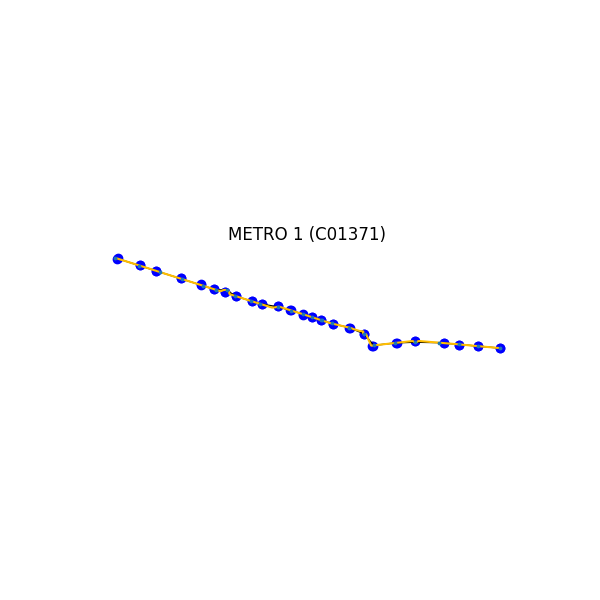

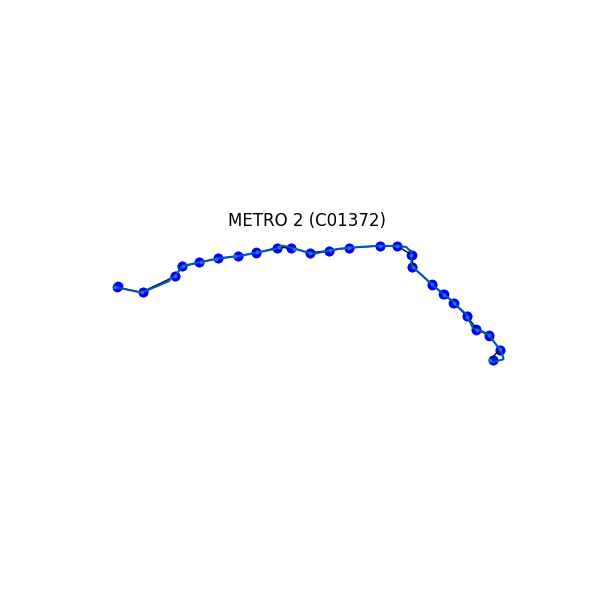

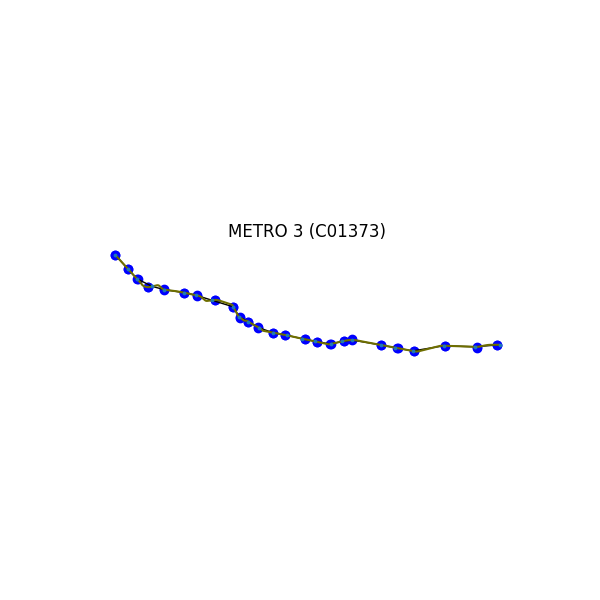

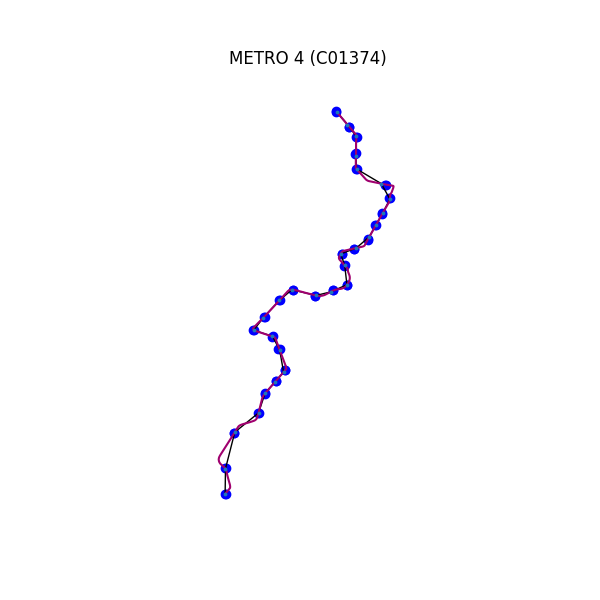

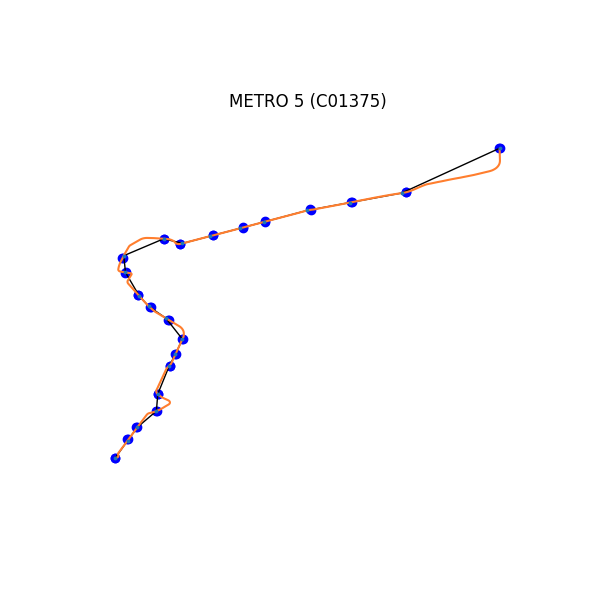

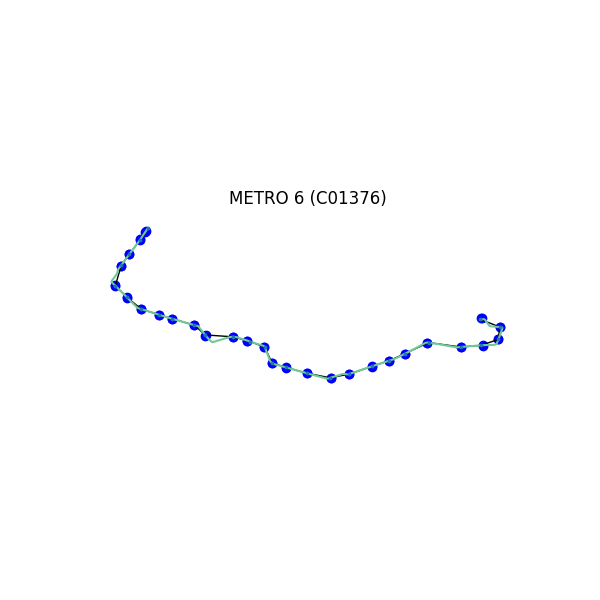

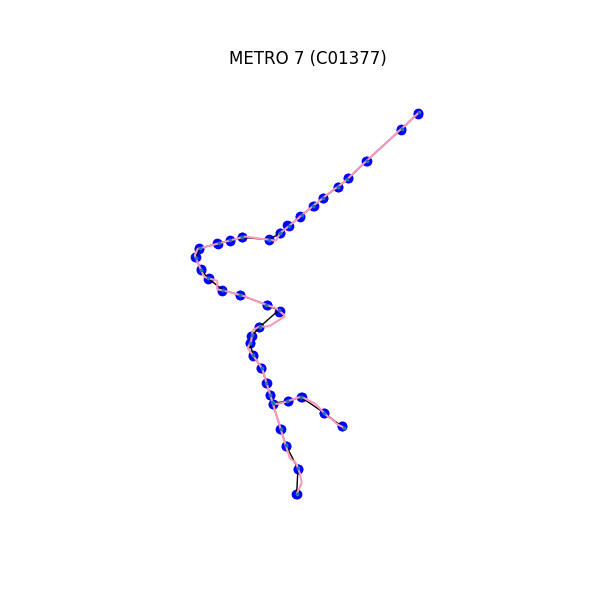

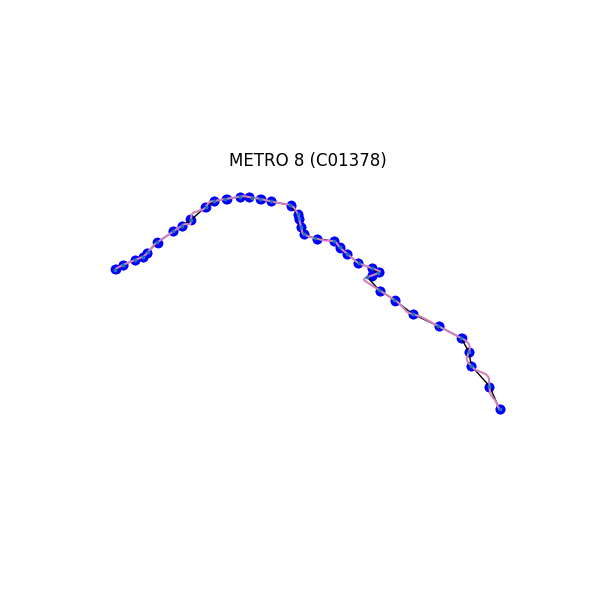

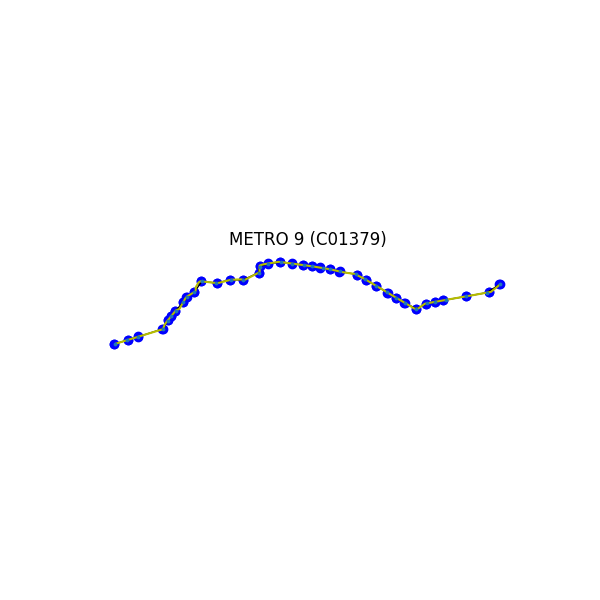

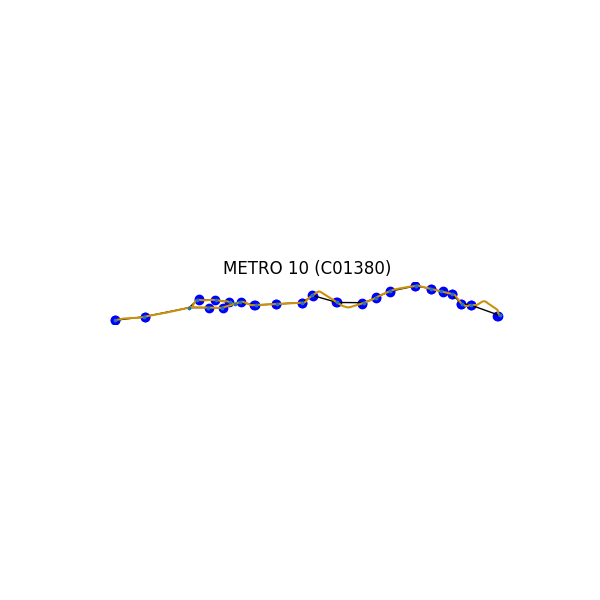

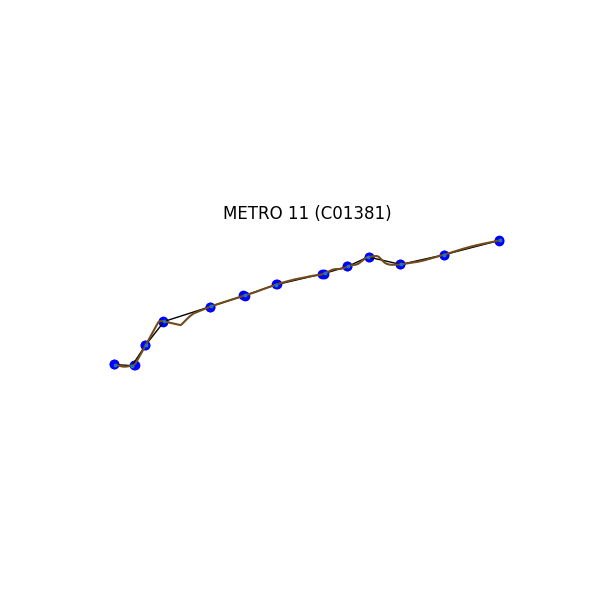

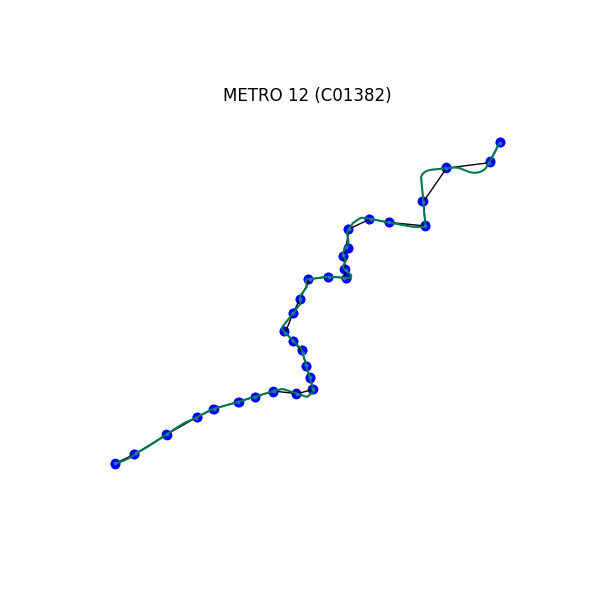

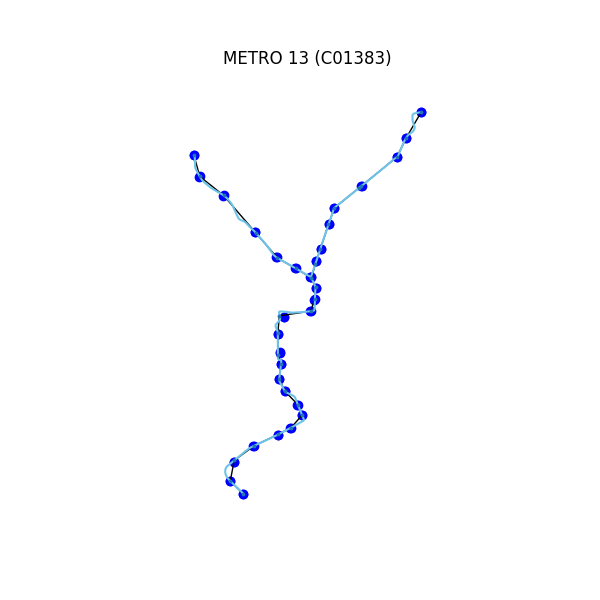

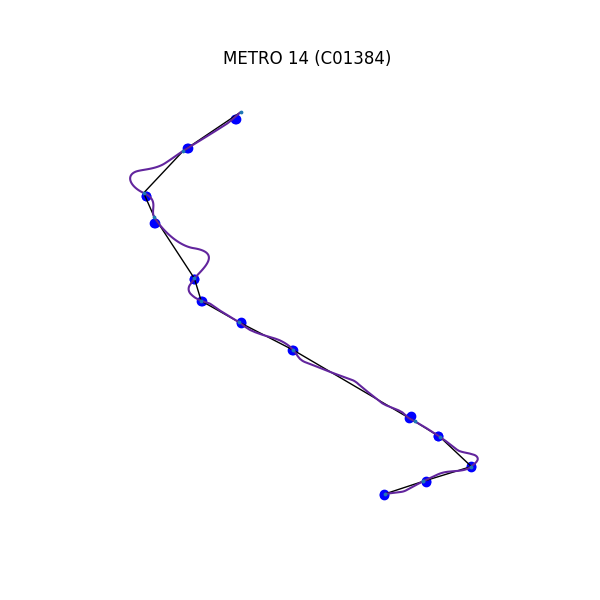

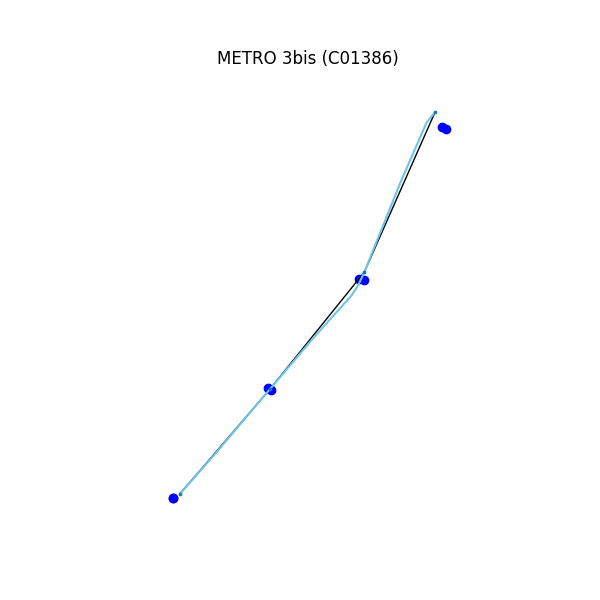

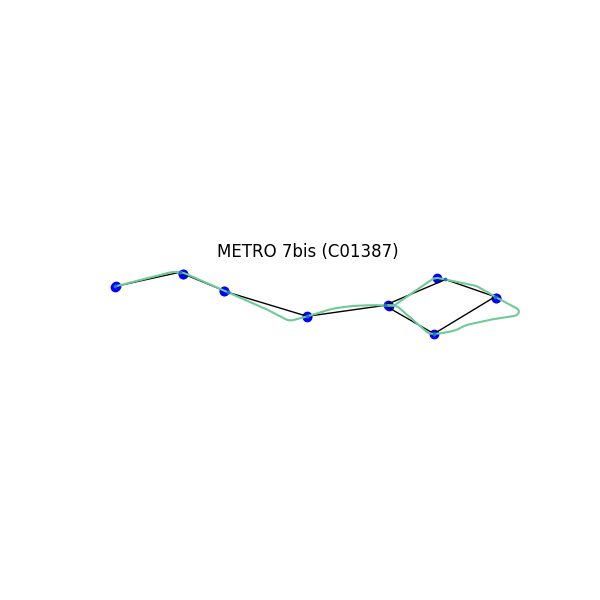

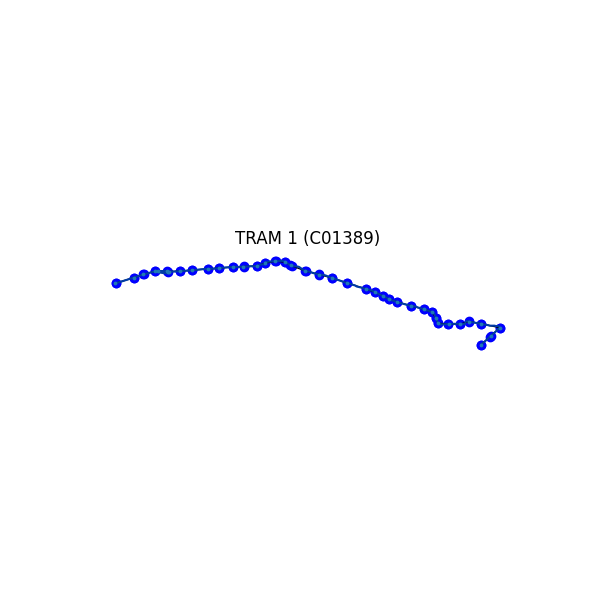

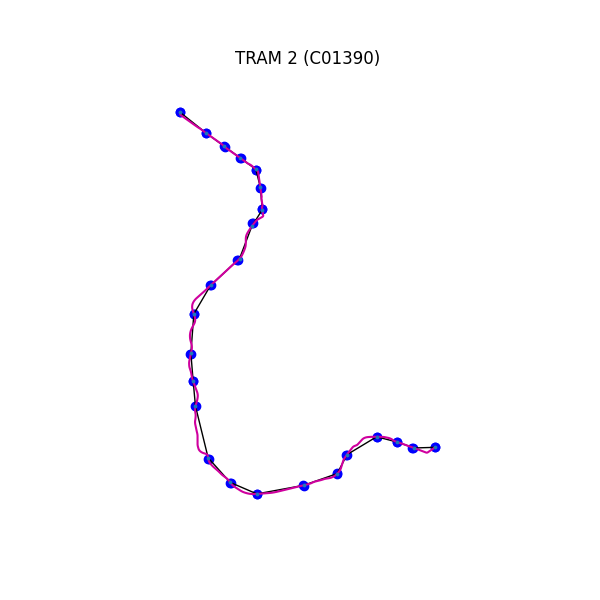

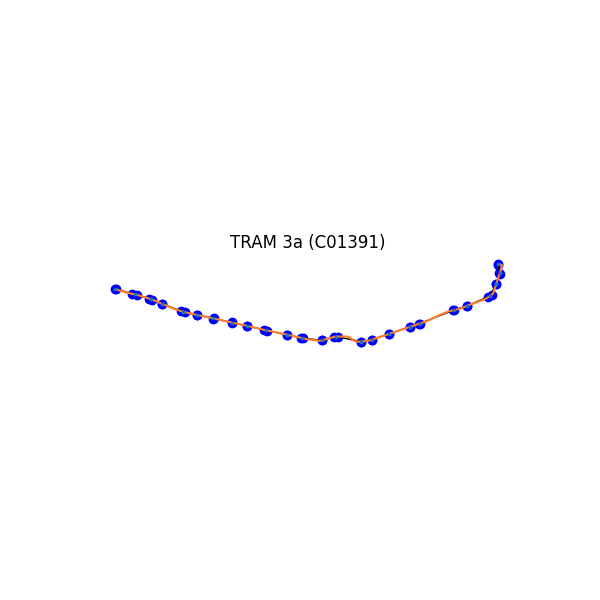

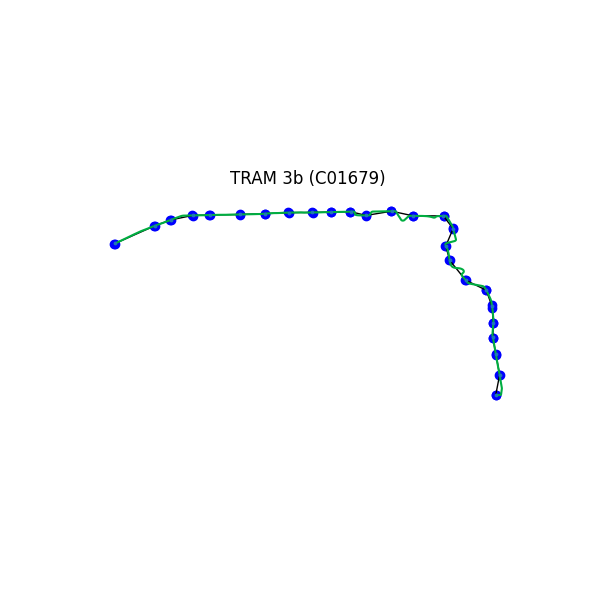

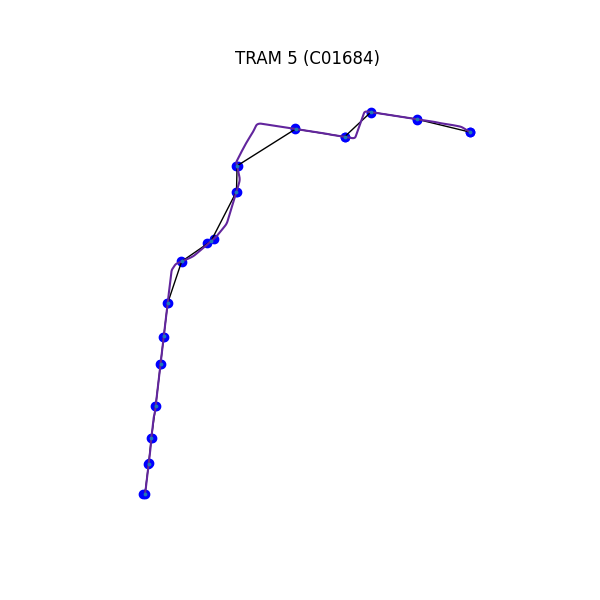

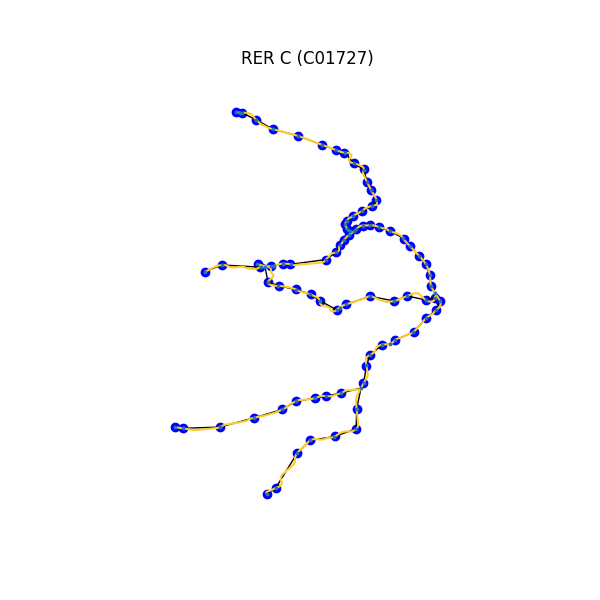

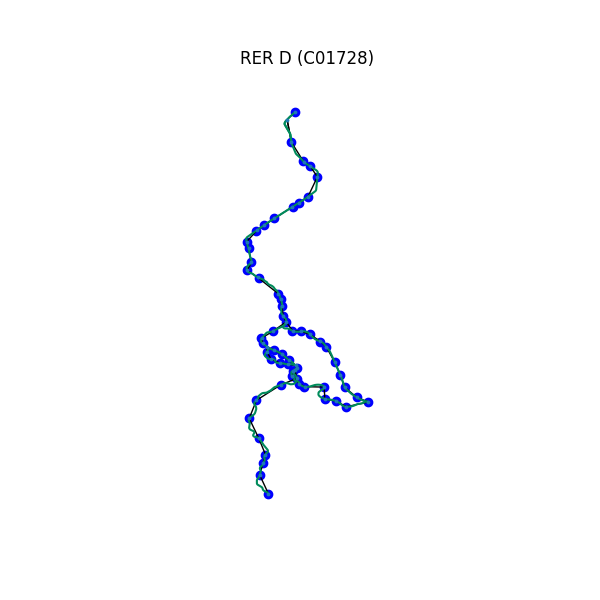

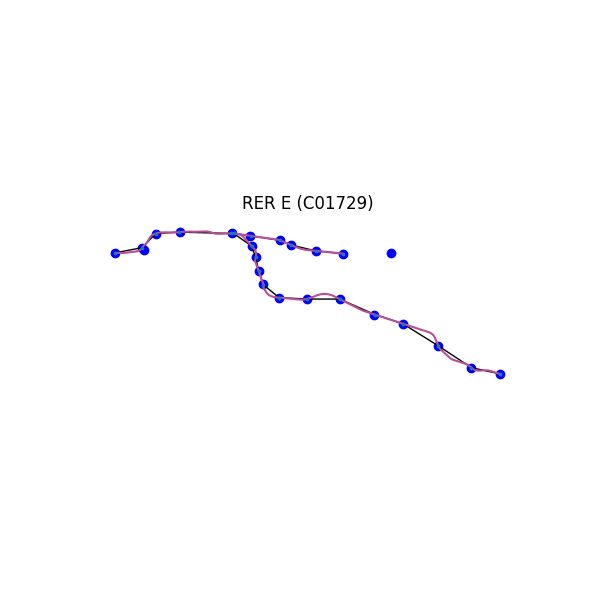

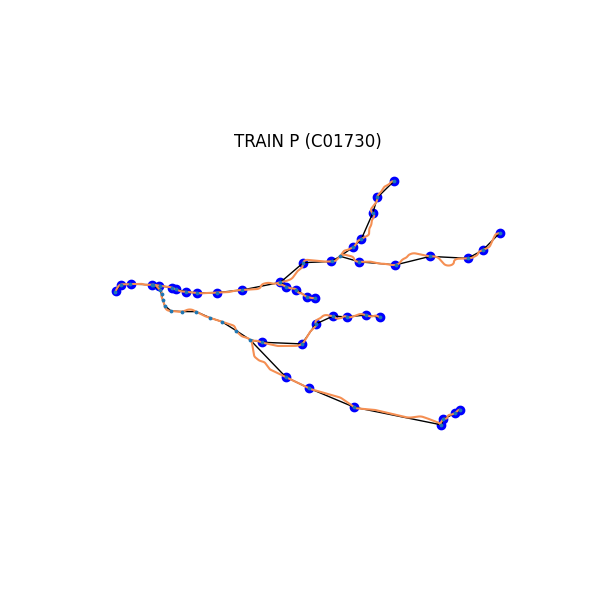

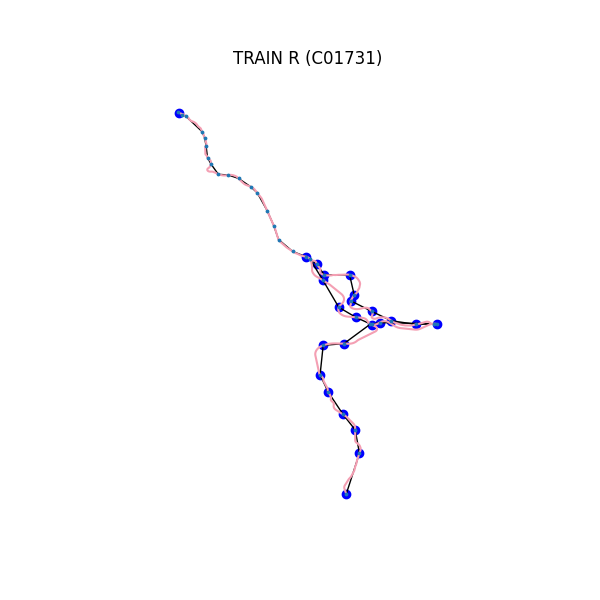

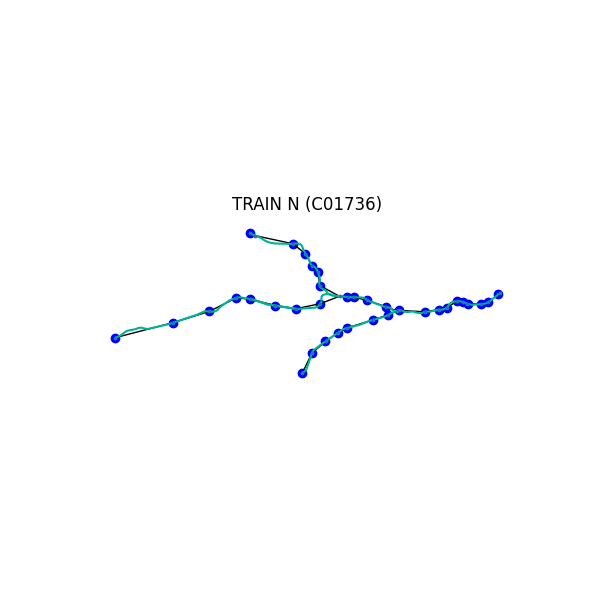

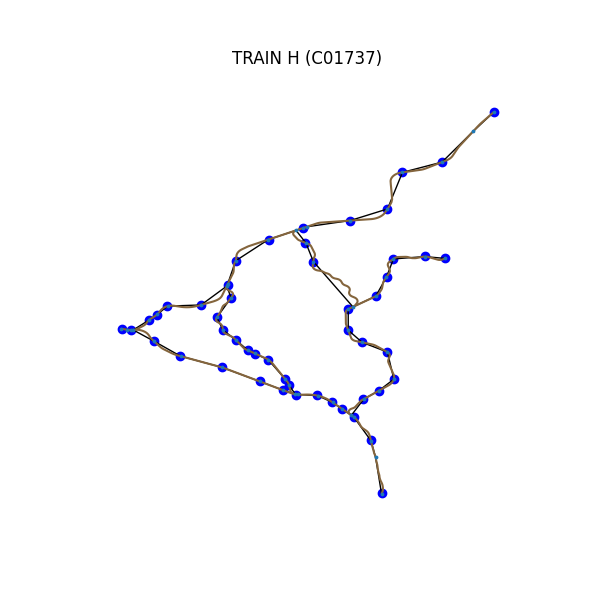

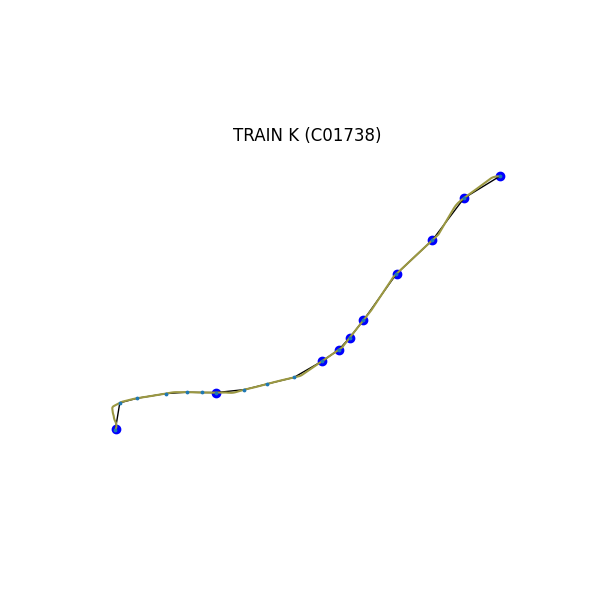

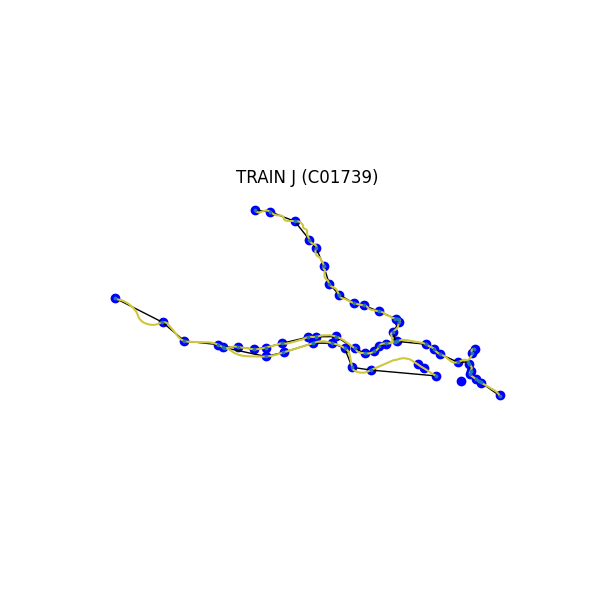

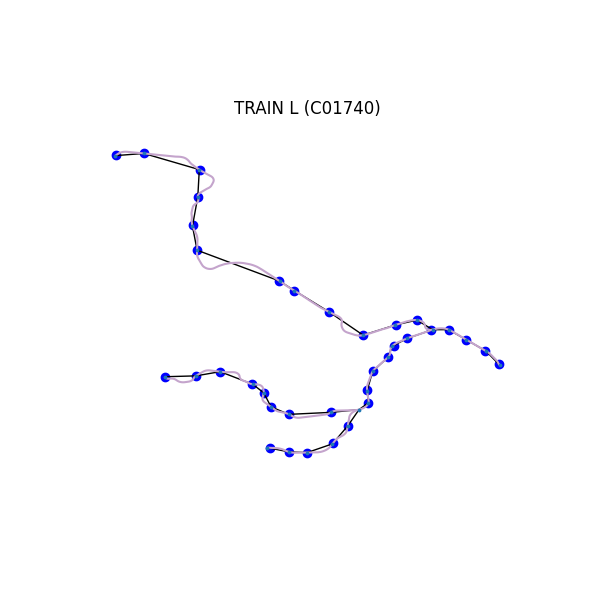

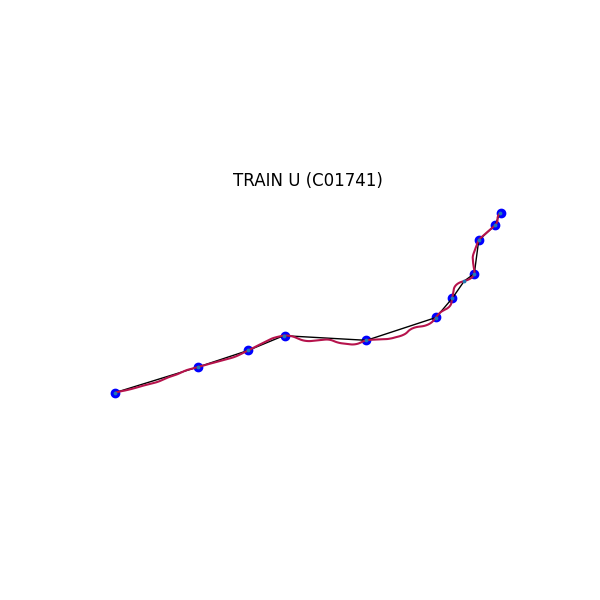

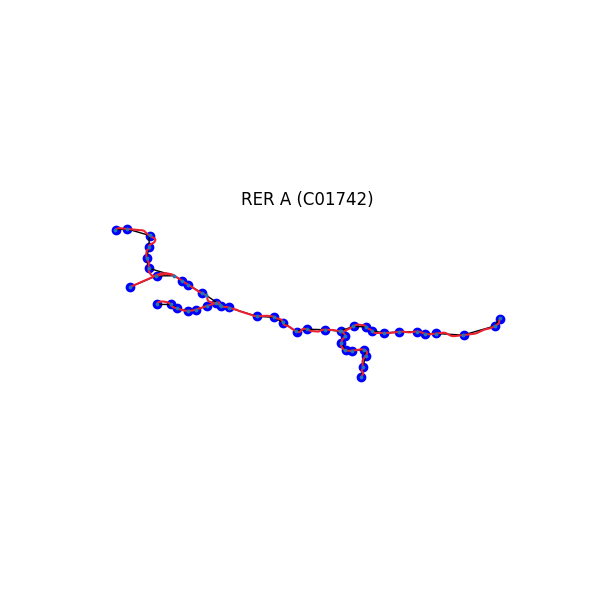

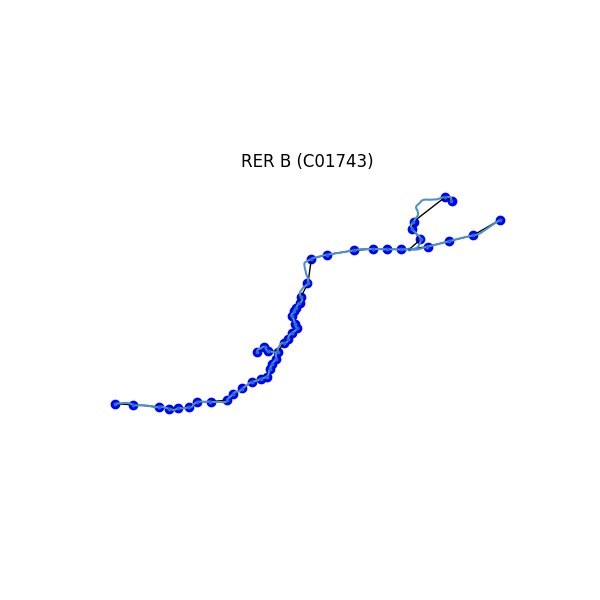

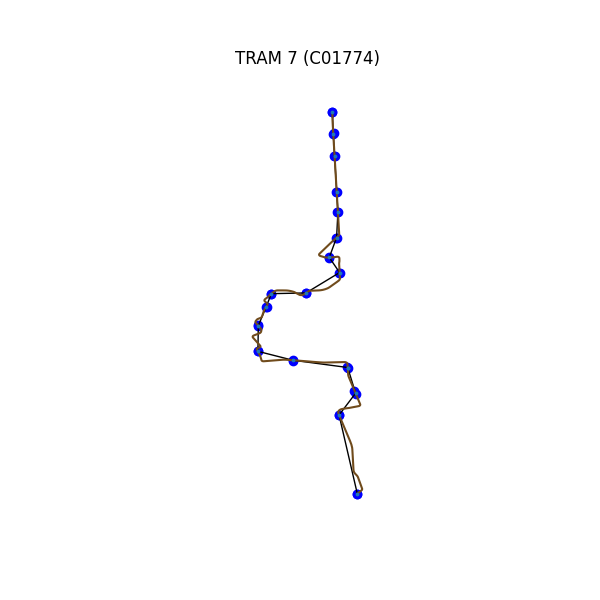

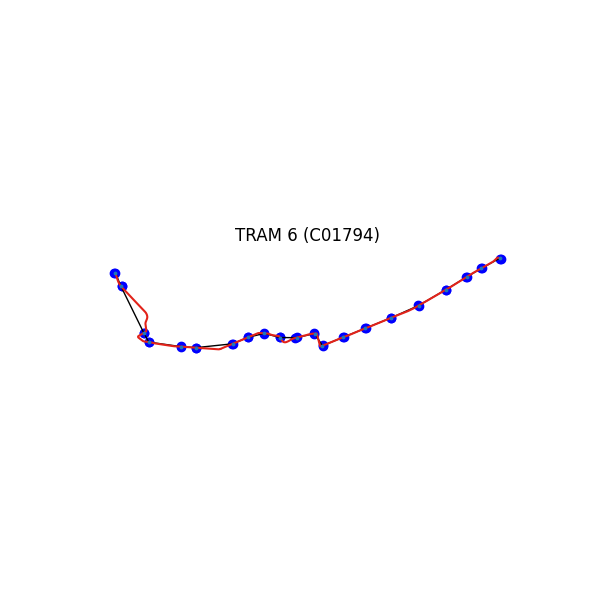

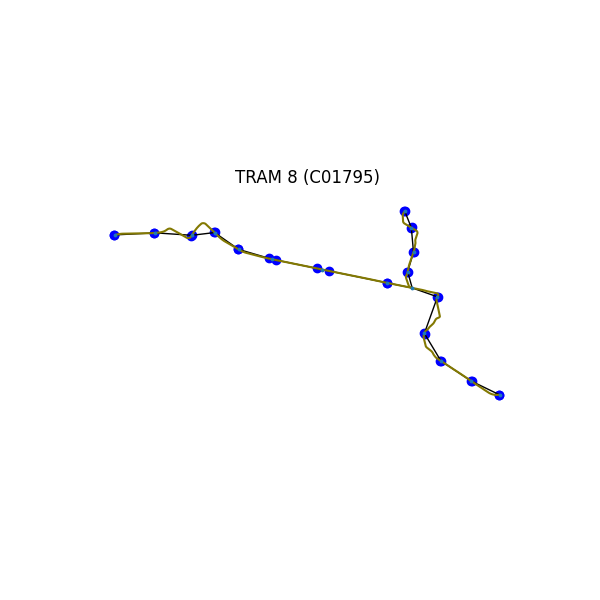

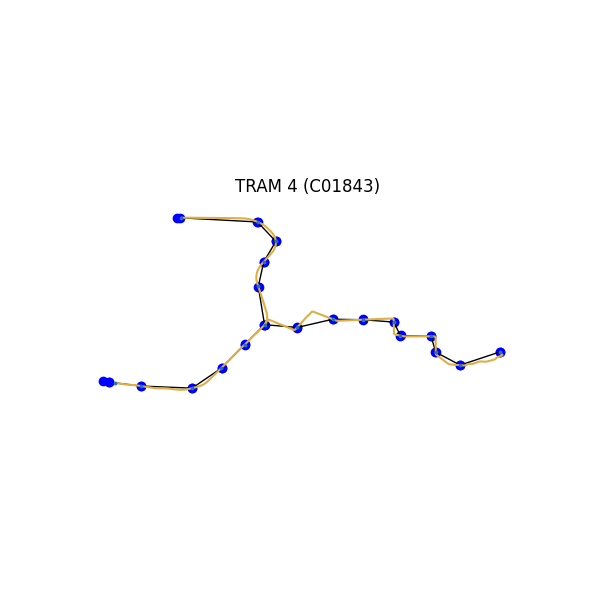

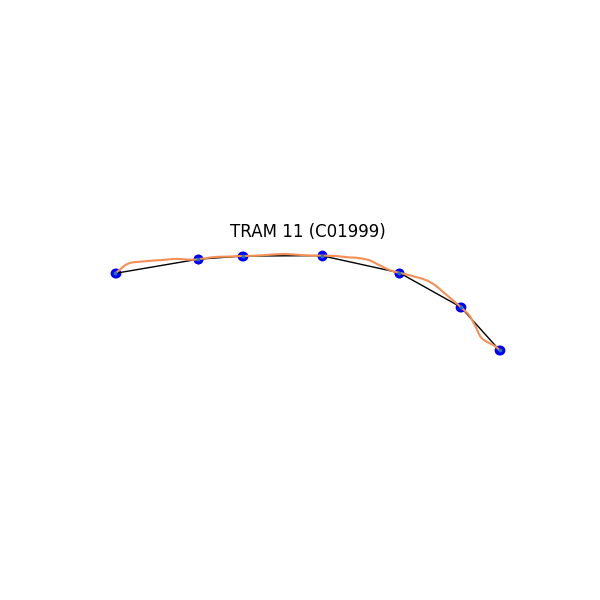

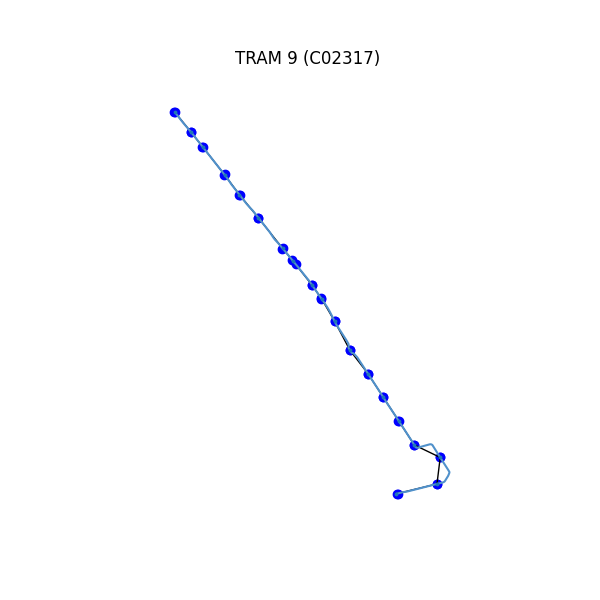

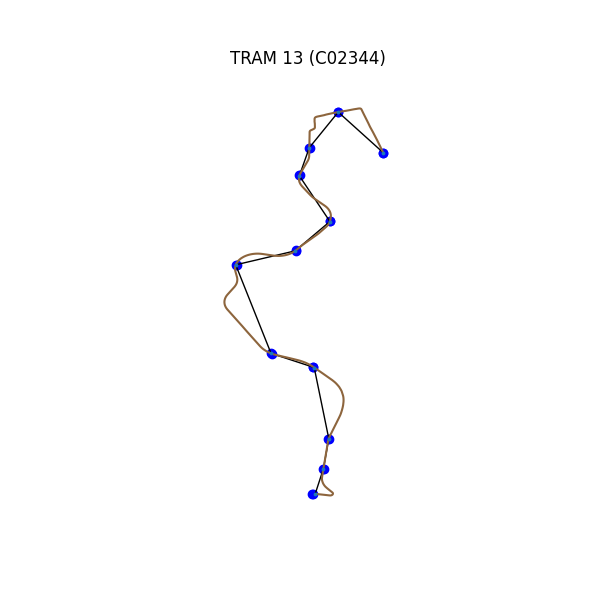

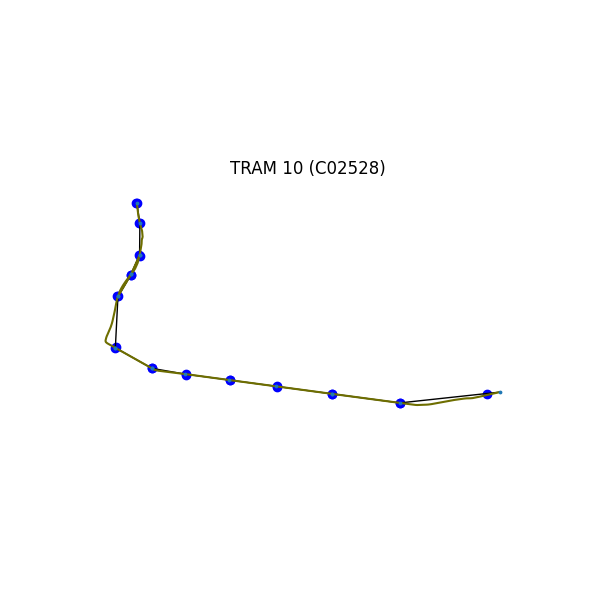

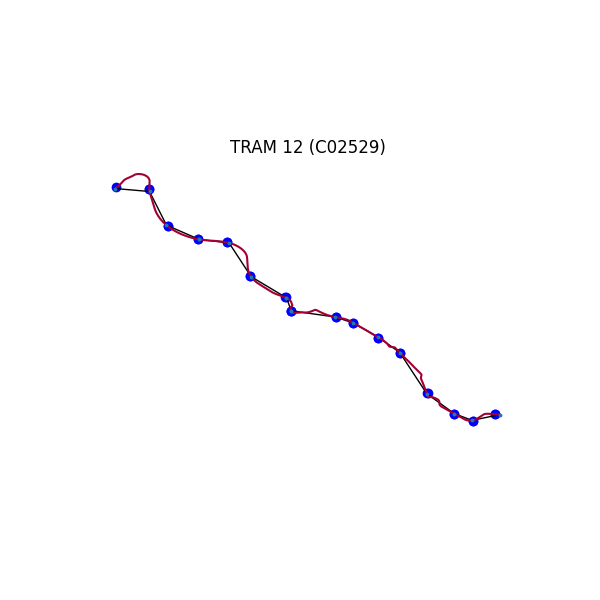

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib widget

for line_id in lines:
    line = lines[line_id]
    G = line['graph']
    network_line = network[network['short_id'] == line_id]

    f, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
    title = f"{network_line['name'].iloc[0]} ({line_id})"
    ax.set_title(title)

    # Plot line
    network_line.plot(color="#"+network_line.color.iloc[0], ax=ax)

    # Plot stops
    stops[stops['line_short_id'] == line_id].plot(color="blue", ax=ax)
    
    # Plot graph nodes
    node_positions = nx.get_node_attributes(G, "position")
    nx.draw(G, pos=node_positions, ax=ax, node_size=3)
    
    plt.show()

In [70]:
# Compute shortest paths on line graph
for line_id in lines:
    line = lines[line_id]
    G = line['graph']

    shortest_paths = nx.shortest_path(G)
    lines[line_id]['shortest_paths'] = shortest_paths

# Print an example
lines[line_id]['shortest_paths']

{0: {0: [0],
  1: [0, 1],
  15: [0, 15],
  8: [0, 1, 8],
  2: [0, 1, 8, 2],
  3: [0, 1, 8, 2, 3],
  6: [0, 1, 8, 2, 3, 6],
  7: [0, 1, 8, 2, 3, 6, 7],
  12: [0, 1, 8, 2, 3, 6, 7, 12],
  13: [0, 1, 8, 2, 3, 6, 7, 12, 13],
  16: [0, 1, 8, 2, 3, 6, 7, 12, 13, 16],
  17: [0, 1, 8, 2, 3, 6, 7, 12, 13, 16, 17],
  4: [0, 1, 8, 2, 3, 6, 7, 12, 13, 16, 17, 4],
  5: [0, 1, 8, 2, 3, 6, 7, 12, 13, 16, 17, 4, 5],
  18: [0, 1, 8, 2, 3, 6, 7, 12, 13, 16, 17, 4, 5, 18],
  9: [0, 1, 8, 2, 3, 6, 7, 12, 13, 16, 17, 4, 5, 18, 9],
  10: [0, 1, 8, 2, 3, 6, 7, 12, 13, 16, 17, 4, 5, 18, 9, 10],
  11: [0, 1, 8, 2, 3, 6, 7, 12, 13, 16, 17, 4, 5, 18, 9, 10, 11],
  14: [0, 1, 8, 2, 3, 6, 7, 12, 13, 16, 17, 4, 5, 18, 9, 10, 11, 14]},
 1: {1: [1],
  0: [1, 0],
  8: [1, 8],
  15: [1, 0, 15],
  2: [1, 8, 2],
  3: [1, 8, 2, 3],
  6: [1, 8, 2, 3, 6],
  7: [1, 8, 2, 3, 6, 7],
  12: [1, 8, 2, 3, 6, 7, 12],
  13: [1, 8, 2, 3, 6, 7, 12, 13],
  16: [1, 8, 2, 3, 6, 7, 12, 13, 16],
  17: [1, 8, 2, 3, 6, 7, 12, 13, 16, 17],
  

## Compute shortest path for each pair of stops on each line

### Enrich network data

In [71]:
# Compute line network with reverse segments.
reversed_network = network.copy()
reversed_network.geometry = reversed_network.geometry.reverse()
network = pd.concat([network, reversed_network])

# Compute positions of (start, end) for each line segment
network['start_pos'] = network.geometry.apply(lambda seg: Point(seg.coords[0]))
network['end_pos'] = network.geometry.apply(lambda seg: Point(seg.coords[-1]))
network

,short_id,geometry,name,company,transportation_type,color,in_idf,picture_url,start_pos,end_pos
0,C01843,"LINESTRING (2.48203 48.89381, 2.48369 48.89357...",TRAM 4,SNCF,TRAMWAY,dfaf47,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (2.48203 48.89381),POINT (2.48791 48.89309)
1,C01728,"LINESTRING (2.45257 48.63427, 2.45168 48.63494...",RER D,SNCF,RER,008b5b,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (2.45257 48.63427),POINT (2.43533 48.64849)
2,C01728,"LINESTRING (2.43533 48.64849, 2.43430 48.64919...",RER D,SNCF,RER,008b5b,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (2.43533 48.64849),POINT (2.41521 48.65898)
3,C01390,"LINESTRING (2.22531 48.82901, 2.22524 48.82939...",TRAM 2,RATP,TRAMWAY,cf009e,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (2.22531 48.82901),POINT (2.22185 48.84312)
4,C01743,"LINESTRING (2.24567 48.71695, 2.24603 48.71739...",RER B,RATP,RER,5091cb,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (2.24567 48.71695),POINT (2.25995 48.72510)
...,...,...,...,...,...,...,...,...,...,...
1306,C02528,"LINESTRING (2.24965 48.76932, 2.24965 48.76932)",TRAM 10,RD Bièvre,TRAMWAY,6e6e00,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (2.24965 48.76932),POINT (2.24965 48.76932)
1307,C02528,"LINESTRING (2.25003 48.77669, 2.25189 48.77984)",TRAM 10,RD Bièvre,TRAMWAY,6e6e00,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (2.25003 48.77669),POINT (2.25189 48.77984)
347,C02529,"LINESTRING (2.29456 48.70224, 2.29456 48.70224)",TRAM 12,SNCF,TRAMWAY,a50034,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (2.29456 48.70224),POINT (2.29456 48.70224)
348,C02529,"LINESTRING (2.33325 48.67638, 2.33325 48.67638)",TRAM 12,SNCF,TRAMWAY,a50034,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (2.33325 48.67638),POINT (2.33325 48.67638)


In [72]:
# Compute node dataframe
nodes = []
for k,v in lines.items():
    df = v['nodes']
    df['line_short_id'] = k
    nodes.append(df)
nodes = pd.concat(nodes).reset_index()
nodes

,index,nodeID,geometry,line_short_id
0,0,0,POINT (2.31355 48.86791),C01371
1,1,1,POINT (2.30861 48.86944),C01371
2,2,2,POINT (2.37377 48.84587),C01371
3,3,3,POINT (2.36867 48.85201),C01371
4,4,4,POINT (2.44044 48.84446),C01371
...,...,...,...,...
1273,14,14,POINT (2.42759 48.62468),C02529
1274,15,15,POINT (2.25752 48.72473),C02529
1275,16,16,POINT (2.33536 48.67064),C02529
1276,17,17,POINT (2.35474 48.66789),C02529


### Create stops pairs

In [73]:
# Create each pair of stops
stops_pairs = []
for line_id in lines:
    line_stops = stops[stops['line_short_id'] == line_id]
    shortest_paths = lines[line_id]['shortest_paths']

    line_stops_pairs = line_stops.assign(dummy=1).merge(line_stops.assign(
        dummy=1), on='dummy', how='outer', suffixes=('_start', '_end'))
    line_stops_pairs = line_stops_pairs.drop('dummy', axis=1)

    # Exclude pairs with identical nodes on graph
    line_stops_pairs = line_stops_pairs[line_stops_pairs.nearest_node_id_start !=
                                        line_stops_pairs.nearest_node_id_end]

    # Compute shortest path for each pair
    line_stops_pairs['shortest_path_nodes'] = line_stops_pairs.apply(
            lambda row: shortest_paths[row.nearest_node_id_start][row.nearest_node_id_end], axis=1)
    stops_pairs.append(line_stops_pairs)

stops_pairs = pd.concat(stops_pairs)
stops_pairs

,id_start,longitude_start,latitude_start,name_start,line_id_start,company_start,line_short_id_start,short_id_start,geometry_start,nearest_node_id_start,...,longitude_end,latitude_end,name_end,line_id_end,company_end,line_short_id_end,short_id_end,geometry_end,nearest_node_id_end,shortest_path_nodes
1,IDFM:22101,2.237988,48.891818,La Défense (Grande Arche),IDFM:C01371,RATP,C01371,22101,POINT (2.23799 48.89182),12,...,2.360885,48.855187,Saint-Paul (Le Marais),IDFM:C01371,RATP,C01371,22074,POINT (2.36089 48.85519),15,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6..."
2,IDFM:22101,2.237988,48.891818,La Défense (Grande Arche),IDFM:C01371,RATP,C01371,22101,POINT (2.23799 48.89182),12,...,2.368693,48.851964,Bastille,IDFM:C01371,RATP,C01371,463019,POINT (2.36869 48.85196),3,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6..."
3,IDFM:22101,2.237988,48.891818,La Défense (Grande Arche),IDFM:C01371,RATP,C01371,22101,POINT (2.23799 48.89182),12,...,2.418962,48.846238,Saint-Mandé,IDFM:C01371,RATP,C01371,22103,POINT (2.41896 48.84624),10,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6..."
4,IDFM:22101,2.237988,48.891818,La Défense (Grande Arche),IDFM:C01371,RATP,C01371,22101,POINT (2.23799 48.89182),12,...,2.429205,48.845406,Bérault,IDFM:C01371,RATP,C01371,22105,POINT (2.42920 48.84541),5,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6..."
5,IDFM:22101,2.237988,48.891818,La Défense (Grande Arche),IDFM:C01371,RATP,C01371,22101,POINT (2.23799 48.89182),12,...,2.440540,48.844318,Château de Vincennes,IDFM:C01371,RATP,C01371,463149,POINT (2.44054 48.84432),4,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,IDFM:486900,2.425463,48.624908,Évry - Courcouronnes,IDFM:C02529,SNCF,C02529,486900,POINT (2.42546 48.62491),14,...,2.280748,48.707984,Champlan,IDFM:C02529,SNCF,C02529,486990,POINT (2.28075 48.70798),1,"[14, 11, 10, 9, 18, 5, 4, 17, 16, 13, 12, 7, 6..."
1018,IDFM:486900,2.425463,48.624908,Évry - Courcouronnes,IDFM:C02529,SNCF,C02529,486900,POINT (2.42546 48.62491),14,...,2.272515,48.724376,Massy Europe,IDFM:C02529,SNCF,C02529,486962,POINT (2.27251 48.72438),0,"[14, 11, 10, 9, 18, 5, 4, 17, 16, 13, 12, 7, 6..."
1019,IDFM:486900,2.425463,48.624908,Évry - Courcouronnes,IDFM:C02529,SNCF,C02529,486900,POINT (2.42546 48.62491),14,...,2.293952,48.702396,Longjumeau,IDFM:C02529,SNCF,C02529,486897,POINT (2.29395 48.70240),8,"[14, 11, 10, 9, 18, 5, 4, 17, 16, 13, 12, 7, 6..."
1020,IDFM:486900,2.425463,48.624908,Évry - Courcouronnes,IDFM:C02529,SNCF,C02529,486900,POINT (2.42546 48.62491),14,...,2.362622,48.665292,Coteaux de l'Orge,IDFM:C02529,SNCF,C02529,486976,POINT (2.36262 48.66529),4,"[14, 11, 10, 9, 18, 5, 4]"


In [74]:
# Get relevant keys for stops_pairs DataFrame

STOP_PAIRS_KEYS = {
    'id_start': 'stop_id_start',
    'short_id_start': 'stop_short_id_start',
    'geometry_start': 'stop_pos_start',
    'name_start': 'stop_name_start',

    'id_end': 'stop_id_end',
    'short_id_end': 'stop_short_id_end',
    'geometry_end': 'stop_pos_end',
    'name_end': 'stop_name_end',

    'line_short_id_start': 'line_short_id',
    'shortest_path_nodes': 'shortest_path_nodes',
}

stops_pairs = stops_pairs[list(STOP_PAIRS_KEYS.keys())].rename(STOP_PAIRS_KEYS, axis='columns')
display(stops_pairs.iloc[0])

stop_id_start                                                 IDFM:22101
stop_short_id_start                                                22101
stop_pos_start              POINT (2.2379881830988277 48.89181786646099)
stop_name_start                                La Défense (Grande Arche)
stop_id_end                                                   IDFM:22074
stop_short_id_end                                                  22074
stop_pos_end                POINT (2.3608852562751967 48.85518742160445)
stop_name_end                                     Saint-Paul (Le Marais)
line_short_id                                                     C01371
shortest_path_nodes    [12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...
Name: 1, dtype: object

### Create segments (parts of a shortest path of stops pairs)

In [75]:
# Decompose each shortest path as pairs of nodes
stops_pairs['shortest_path_segment'] = stops_pairs['shortest_path_nodes'].apply(lambda x: list(zip(x[:-1], x[1:])))
stops_pairs.head()

,stop_id_start,stop_short_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_short_id_end,stop_pos_end,stop_name_end,line_short_id,shortest_path_nodes,shortest_path_segment
1,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22074,22074,POINT (2.36089 48.85519),Saint-Paul (Le Marais),C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...","[(12, 11), (11, 22), (22, 21), (21, 24), (24, ..."
2,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:463019,463019,POINT (2.36869 48.85196),Bastille,C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...","[(12, 11), (11, 22), (22, 21), (21, 24), (24, ..."
3,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22103,22103,POINT (2.41896 48.84624),Saint-Mandé,C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...","[(12, 11), (11, 22), (22, 21), (21, 24), (24, ..."
4,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22105,22105,POINT (2.42920 48.84541),Bérault,C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...","[(12, 11), (11, 22), (22, 21), (21, 24), (24, ..."
5,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:463149,463149,POINT (2.44054 48.84432),Château de Vincennes,C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...","[(12, 11), (11, 22), (22, 21), (21, 24), (24, ..."


### Get information about segments of each shortest path

In [76]:
# Flatten pairs of nodes for each shortest path
segments = stops_pairs.explode('shortest_path_segment').reset_index()
segments = segments.drop(['index'], axis=1)
segments['start_node'] = segments['shortest_path_segment'].apply(lambda x: x[0])
segments['end_node'] = segments['shortest_path_segment'].apply(lambda x: x[1])
segments = segments.drop(['shortest_path_segment'], axis=1)
segments.head()

,stop_id_start,stop_short_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_short_id_end,stop_pos_end,stop_name_end,line_short_id,shortest_path_nodes,start_node,end_node
0,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22074,22074,POINT (2.36089 48.85519),Saint-Paul (Le Marais),C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...",12,11
1,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22074,22074,POINT (2.36089 48.85519),Saint-Paul (Le Marais),C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...",11,22
2,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22074,22074,POINT (2.36089 48.85519),Saint-Paul (Le Marais),C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...",22,21
3,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22074,22074,POINT (2.36089 48.85519),Saint-Paul (Le Marais),C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...",21,24
4,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22074,22074,POINT (2.36089 48.85519),Saint-Paul (Le Marais),C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...",24,14


In [77]:
# Shortest path segment example
segments[(segments.stop_id_start=="IDFM:21784") & (segments.stop_id_end=="IDFM:22096")]

,stop_id_start,stop_short_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_short_id_end,stop_pos_end,stop_name_end,line_short_id,shortest_path_nodes,start_node,end_node
248495,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",14,13
248496,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",13,11
248497,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",11,12
248498,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",12,30
248499,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",30,24
248500,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",24,25
248501,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",25,36
248502,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",36,31
248503,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",31,32
248504,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",32,7


In [78]:
# Shortest path segment example (stop belonging to two lines)
segments[(segments.stop_id_start=="IDFM:monomodalStopPlace:47940") & (segments.stop_id_end=="IDFM:monomodalStopPlace:58774")]

,stop_id_start,stop_short_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_short_id_end,stop_pos_end,stop_name_end,line_short_id,shortest_path_nodes,start_node,end_node
670156,IDFM:monomodalStopPlace:47940,47940,POINT (2.27395 48.73499),Massy - Verrières,IDFM:monomodalStopPlace:58774,58774,POINT (2.25877 48.72552),Massy - Palaiseau,C01727,"[0, 25, 24]",0,25
670157,IDFM:monomodalStopPlace:47940,47940,POINT (2.27395 48.73499),Massy - Verrières,IDFM:monomodalStopPlace:58774,58774,POINT (2.25877 48.72552),Massy - Palaiseau,C01727,"[0, 25, 24]",25,24
920964,IDFM:monomodalStopPlace:47940,47940,POINT (2.27395 48.73499),Massy - Verrières,IDFM:monomodalStopPlace:58774,58774,POINT (2.25877 48.72552),Massy - Palaiseau,C01743,"[16, 1]",16,1


In [79]:
# Get node positions
segments = segments.merge(nodes,
                          left_on=['start_node', 'line_short_id'],
                          right_on=['nodeID', 'line_short_id'],
                          how='inner', suffixes=('_segment', '_start_node'))
segments['start_pos'] = segments.geometry
segments = segments.drop(['geometry', 'nodeID'], axis=1)
segments = segments.merge(nodes,
                          left_on=['end_node', 'line_short_id'],
                          right_on=['nodeID', 'line_short_id'],
                          how='inner', suffixes=('_segment', '_end_node'))
segments['end_pos'] = segments.geometry
segments = segments.drop(['geometry', 'nodeID'], axis=1)                 

segments = segments.drop(['index_end_node', 'index_segment'], axis=1)

segments.head()

,stop_id_start,stop_short_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_short_id_end,stop_pos_end,stop_name_end,line_short_id,shortest_path_nodes,start_node,end_node,start_pos,end_pos
0,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22074,22074,POINT (2.36089 48.85519),Saint-Paul (Le Marais),C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...",12,11,POINT (2.23702 48.89219),POINT (2.24979 48.88814)
1,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:463019,463019,POINT (2.36869 48.85196),Bastille,C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...",12,11,POINT (2.23702 48.89219),POINT (2.24979 48.88814)
2,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22103,22103,POINT (2.41896 48.84624),Saint-Mandé,C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...",12,11,POINT (2.23702 48.89219),POINT (2.24979 48.88814)
3,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22105,22105,POINT (2.42920 48.84541),Bérault,C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...",12,11,POINT (2.23702 48.89219),POINT (2.24979 48.88814)
4,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:463149,463149,POINT (2.44054 48.84432),Château de Vincennes,C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...",12,11,POINT (2.23702 48.89219),POINT (2.24979 48.88814)


In [80]:
# Shortest path segments example
sp_ex1 = segments[(segments.stop_id_start=="IDFM:21784") & (segments.stop_id_end=="IDFM:22096")]
display(sp_ex1.shape)
sp_ex1

(28, 14)

,stop_id_start,stop_short_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_short_id_end,stop_pos_end,stop_name_end,line_short_id,shortest_path_nodes,start_node,end_node,start_pos,end_pos
220911,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",9,2,POINT (2.32627 48.86963),POINT (2.32208 48.86682)
223189,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",6,9,POINT (2.33119 48.87048),POINT (2.32627 48.86963)
225575,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",5,6,POINT (2.33846 48.87169),POINT (2.33119 48.87048)
228073,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",4,5,POINT (2.34456 48.87126),POINT (2.33846 48.87169)
230667,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",35,4,POINT (2.34849 48.87059),POINT (2.34456 48.87126)
233371,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",27,35,POINT (2.35382 48.86940),POINT (2.34849 48.87059)
236143,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",26,27,POINT (2.36276 48.86760),POINT (2.35382 48.86940)
238967,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",34,26,POINT (2.36666 48.86326),POINT (2.36276 48.86760)
241827,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",19,34,POINT (2.36721 48.86117),POINT (2.36666 48.86326)
244707,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",18,19,POINT (2.36818 48.85710),POINT (2.36721 48.86117)


In [81]:
# Get LineString for each segment
segments = segments.merge(network.add_prefix('line_'),
                          left_on=['start_pos', 'end_pos', 'line_short_id'],
                          right_on=['line_start_pos', 'line_end_pos', 'line_short_id'],
                          how='inner')
segments = segments.drop(['line_company', 'line_color',
                         'line_in_idf', 'line_picture_url', 'line_start_pos', 'line_end_pos'], axis=1)
segments.head()

,stop_id_start,stop_short_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_short_id_end,stop_pos_end,stop_name_end,line_short_id,shortest_path_nodes,start_node,end_node,start_pos,end_pos,line_geometry,line_name,line_transportation_type
0,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22074,22074,POINT (2.36089 48.85519),Saint-Paul (Le Marais),C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...",12,11,POINT (2.23702 48.89219),POINT (2.24979 48.88814),"LINESTRING (2.23702 48.89219, 2.23721 48.89212...",METRO 1,METRO
1,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:463019,463019,POINT (2.36869 48.85196),Bastille,C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...",12,11,POINT (2.23702 48.89219),POINT (2.24979 48.88814),"LINESTRING (2.23702 48.89219, 2.23721 48.89212...",METRO 1,METRO
2,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22103,22103,POINT (2.41896 48.84624),Saint-Mandé,C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...",12,11,POINT (2.23702 48.89219),POINT (2.24979 48.88814),"LINESTRING (2.23702 48.89219, 2.23721 48.89212...",METRO 1,METRO
3,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22105,22105,POINT (2.42920 48.84541),Bérault,C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...",12,11,POINT (2.23702 48.89219),POINT (2.24979 48.88814),"LINESTRING (2.23702 48.89219, 2.23721 48.89212...",METRO 1,METRO
4,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:463149,463149,POINT (2.44054 48.84432),Château de Vincennes,C01371,"[12, 11, 22, 21, 24, 14, 13, 25, 1, 0, 8, 7, 6...",12,11,POINT (2.23702 48.89219),POINT (2.24979 48.88814),"LINESTRING (2.23702 48.89219, 2.23721 48.89212...",METRO 1,METRO


In [82]:
# Shortest path segments example
sp_ex2 = segments[(segments.stop_id_start=="IDFM:21784") & (segments.stop_id_end=="IDFM:22096")]
display(sp_ex2.shape)
sp_ex2

(28, 17)

,stop_id_start,stop_short_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_short_id_end,stop_pos_end,stop_name_end,line_short_id,shortest_path_nodes,start_node,end_node,start_pos,end_pos,line_geometry,line_name,line_transportation_type
220911,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",9,2,POINT (2.32627 48.86963),POINT (2.32208 48.86682),"LINESTRING (2.32627 48.86963, 2.32550 48.86950...",METRO 8,METRO
223189,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",6,9,POINT (2.33119 48.87048),POINT (2.32627 48.86963),"LINESTRING (2.33119 48.87048, 2.32792 48.86992...",METRO 8,METRO
225575,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",5,6,POINT (2.33846 48.87169),POINT (2.33119 48.87048),"LINESTRING (2.33846 48.87169, 2.33257 48.87071...",METRO 8,METRO
228073,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",4,5,POINT (2.34456 48.87126),POINT (2.33846 48.87169),"LINESTRING (2.34456 48.87126, 2.34092 48.87187...",METRO 8,METRO
230667,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",35,4,POINT (2.34849 48.87059),POINT (2.34456 48.87126),"LINESTRING (2.34849 48.87059, 2.34798 48.87070...",METRO 8,METRO
233371,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",27,35,POINT (2.35382 48.86940),POINT (2.34849 48.87059),"LINESTRING (2.35382 48.86940, 2.35358 48.86945...",METRO 8,METRO
236143,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",26,27,POINT (2.36276 48.86760),POINT (2.35382 48.86940),"LINESTRING (2.36276 48.86760, 2.36237 48.86780...",METRO 8,METRO
238967,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",34,26,POINT (2.36666 48.86326),POINT (2.36276 48.86760),"LINESTRING (2.36666 48.86326, 2.36619 48.86405...",METRO 8,METRO
241827,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",19,34,POINT (2.36721 48.86117),POINT (2.36666 48.86326),"LINESTRING (2.36721 48.86117, 2.36686 48.86268...",METRO 8,METRO
244707,IDFM:21784,21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,22096,POINT (2.32203 48.86652),Concorde,C01378,"[14, 13, 11, 12, 30, 24, 25, 36, 31, 32, 7, 8,...",18,19,POINT (2.36818 48.85710),POINT (2.36721 48.86117),"LINESTRING (2.36818 48.85710, 2.36741 48.86033...",METRO 8,METRO


In [83]:
SEGMENTS_KEYS_TO_KEEP = ['stop_id_start',
                         'stop_short_id_start',
                         'stop_pos_start',
                         'stop_name_start',
                         'stop_id_end',
                         'stop_short_id_end',
                         'stop_pos_end',
                         'stop_name_end',
                         'line_short_id',
                         'line_name',
                         'line_transportation_type',
                         'line_geometry',
                         ]
segments = segments[SEGMENTS_KEYS_TO_KEEP]
segments

,stop_id_start,stop_short_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_short_id_end,stop_pos_end,stop_name_end,line_short_id,line_name,line_transportation_type,line_geometry
0,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22074,22074,POINT (2.36089 48.85519),Saint-Paul (Le Marais),C01371,METRO 1,METRO,"LINESTRING (2.23702 48.89219, 2.23721 48.89212..."
1,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:463019,463019,POINT (2.36869 48.85196),Bastille,C01371,METRO 1,METRO,"LINESTRING (2.23702 48.89219, 2.23721 48.89212..."
2,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22103,22103,POINT (2.41896 48.84624),Saint-Mandé,C01371,METRO 1,METRO,"LINESTRING (2.23702 48.89219, 2.23721 48.89212..."
3,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:22105,22105,POINT (2.42920 48.84541),Bérault,C01371,METRO 1,METRO,"LINESTRING (2.23702 48.89219, 2.23721 48.89212..."
4,IDFM:22101,22101,POINT (2.23799 48.89182),La Défense (Grande Arche),IDFM:463149,463149,POINT (2.44054 48.84432),Château de Vincennes,C01371,METRO 1,METRO,"LINESTRING (2.23702 48.89219, 2.23721 48.89212..."
...,...,...,...,...,...,...,...,...,...,...,...,...
995485,IDFM:486897,486897,POINT (2.29395 48.70240),Longjumeau,IDFM:486883,486883,POINT (2.25768 48.72532),Massy-Palaiseau,C02529,TRAM 12,TRAMWAY,"LINESTRING (2.27264 48.72343, 2.27261 48.72362..."
995486,IDFM:486976,486976,POINT (2.36262 48.66529),Coteaux de l'Orge,IDFM:486883,486883,POINT (2.25768 48.72532),Massy-Palaiseau,C02529,TRAM 12,TRAMWAY,"LINESTRING (2.27264 48.72343, 2.27261 48.72362..."
995487,IDFM:486965,486965,POINT (2.40733 48.62511),Traité de Rome,IDFM:486883,486883,POINT (2.25768 48.72532),Massy-Palaiseau,C02529,TRAM 12,TRAMWAY,"LINESTRING (2.27264 48.72343, 2.27261 48.72362..."
995488,IDFM:486902,486902,POINT (2.42549 48.62495),Évry - Courcouronnes,IDFM:486883,486883,POINT (2.25768 48.72532),Massy-Palaiseau,C02529,TRAM 12,TRAMWAY,"LINESTRING (2.27264 48.72343, 2.27261 48.72362..."


In [84]:
# segments[(segments.id_start=="IDFM:463197") & (segments.id_end=="IDFM:463160")]
segments[(segments.stop_id_start=="IDFM:21784") & (segments.stop_id_end=="IDFM:22096")]
segments[(segments.stop_id_start=="IDFM:monomodalStopPlace:47940") & (segments.stop_id_end=="IDFM:monomodalStopPlace:58774")]

,stop_id_start,stop_short_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_short_id_end,stop_pos_end,stop_name_end,line_short_id,line_name,line_transportation_type,line_geometry
663080,IDFM:monomodalStopPlace:47940,47940,POINT (2.27395 48.73499),Massy - Verrières,IDFM:monomodalStopPlace:58774,58774,POINT (2.25877 48.72552),Massy - Palaiseau,C01727,RER C,RER,"LINESTRING (2.27400 48.73489, 2.27348 48.73472..."
664072,IDFM:monomodalStopPlace:47940,47940,POINT (2.27395 48.73499),Massy - Verrières,IDFM:monomodalStopPlace:58774,58774,POINT (2.25877 48.72552),Massy - Palaiseau,C01727,RER C,RER,"LINESTRING (2.26307 48.72965, 2.26285 48.72955..."
931926,IDFM:monomodalStopPlace:47940,47940,POINT (2.27395 48.73499),Massy - Verrières,IDFM:monomodalStopPlace:58774,58774,POINT (2.25877 48.72552),Massy - Palaiseau,C01743,RER B,RER,"LINESTRING (2.27400 48.73489, 2.27348 48.73472..."


### Merge each shortest path segment to get shortest path LineString

In [85]:
from shapely.ops import linemerge

# Merge each segments of paths
shortest_paths = segments.groupby(['stop_id_start', 'stop_id_end', 'line_short_id'])
params = {
    'stop_short_id_start': 'first',
    'stop_short_id_end': 'first',
    'stop_name_start': 'first',
    'stop_name_end': 'first',
    'line_name': 'first',
    'line_transportation_type': 'first',
    'line_geometry': linemerge
}
shortest_paths = shortest_paths.agg(params).reset_index()
shortest_paths = gpd.GeoDataFrame(shortest_paths).set_geometry('line_geometry')
shortest_paths = shortest_paths.set_crs(4326)
shortest_paths.head()

,stop_id_start,stop_id_end,line_short_id,stop_short_id_start,stop_short_id_end,stop_name_start,stop_name_end,line_name,line_transportation_type,line_geometry
0,IDFM:21784,IDFM:22096,C01378,21784,22096,Pointe du Lac,Concorde,METRO 8,METRO,"LINESTRING (2.46428 48.76881, 2.46356 48.76984..."
1,IDFM:21784,IDFM:22097,C01378,21784,22097,Pointe du Lac,Bastille,METRO 8,METRO,"LINESTRING (2.46428 48.76881, 2.46356 48.76984..."
2,IDFM:21784,IDFM:22098,C01378,21784,22098,Pointe du Lac,Reuilly - Diderot,METRO 8,METRO,"LINESTRING (2.46428 48.76881, 2.46356 48.76984..."
3,IDFM:21784,IDFM:22159,C01378,21784,22159,Pointe du Lac,Strasbourg - Saint-Denis,METRO 8,METRO,"LINESTRING (2.46428 48.76881, 2.46356 48.76984..."
4,IDFM:21784,IDFM:22183,C01378,21784,22183,Pointe du Lac,La Motte-Picquet - Grenelle,METRO 8,METRO,"LINESTRING (2.46428 48.76881, 2.46356 48.76984..."


,stop_id_start,stop_id_end,line_short_id,stop_short_id_start,stop_short_id_end,stop_name_start,stop_name_end,line_name,line_transportation_type,line_geometry
0,IDFM:21784,IDFM:22096,C01378,21784,22096,Pointe du Lac,Concorde,METRO 8,METRO,"LINESTRING (2.46428 48.76881, 2.46356 48.76984..."


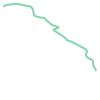

In [86]:
# Shortest path example
display(shortest_paths[(shortest_paths.stop_id_start=="IDFM:21784") & (shortest_paths.stop_id_end=="IDFM:22096")])
shortest_paths[(shortest_paths.stop_id_start=="IDFM:21784") & (shortest_paths.stop_id_end=="IDFM:22096")].line_geometry.iloc[0]

,stop_id_start,stop_id_end,line_short_id,stop_short_id_start,stop_short_id_end,stop_name_start,stop_name_end,line_name,line_transportation_type,line_geometry
52077,IDFM:463197,IDFM:463160,C01371,463197,463160,Gare de Lyon,Châtelet,METRO 1,METRO,"LINESTRING (2.37377 48.84587, 2.37294 48.84575..."


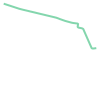

In [87]:
# Shortest path example 2
display(shortest_paths[(shortest_paths.stop_id_start=="IDFM:463197") & (shortest_paths.stop_id_end=="IDFM:463160")])
shortest_paths[(shortest_paths.stop_id_start=="IDFM:463197") & (shortest_paths.stop_id_end=="IDFM:463160")].line_geometry.iloc[0]

,stop_id_start,stop_id_end,line_short_id,stop_short_id_start,stop_short_id_end,stop_name_start,stop_name_end,line_name,line_transportation_type,line_geometry
87796,IDFM:monomodalStopPlace:47940,IDFM:monomodalStopPlace:58774,C01727,47940,58774,Massy - Verrières,Massy - Palaiseau,RER C,RER,"LINESTRING (2.27400 48.73489, 2.27348 48.73472..."
87797,IDFM:monomodalStopPlace:47940,IDFM:monomodalStopPlace:58774,C01743,47940,58774,Massy - Verrières,Massy - Palaiseau,RER B,RER,"LINESTRING (2.27400 48.73489, 2.27348 48.73472..."


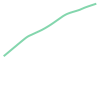

In [88]:
# Shortest path example 3
display(shortest_paths[(shortest_paths.stop_id_start=="IDFM:monomodalStopPlace:47940") & (shortest_paths.stop_id_end=="IDFM:monomodalStopPlace:58774")])
shortest_paths[(shortest_paths.stop_id_start=="IDFM:monomodalStopPlace:47940") & (shortest_paths.stop_id_end=="IDFM:monomodalStopPlace:58774")].line_geometry.iloc[0]

### Interpolate each shortest path
This yields interpolated shortest paths with one point every 10 meter.

In [89]:
# Interpolation
from pyproj import Geod
import numpy as np


def interpolate_linestring(line, length, distance_between_points=None):
    if distance_between_points and distance_between_points > 0:
        n = round(length / distance_between_points)
    else:
        n = 10

    interpolation_point_distances = np.linspace(0, line.length, n)
    interpolated_points = [line.interpolate(
        distance) for distance in interpolation_point_distances]
    interpolated_line = LineString(interpolated_points)
    return interpolated_line


DISTANCE_BETWEEN_POINTS = 40  # in meters

shortest_paths['line_geometry_length'] = shortest_paths.line_geometry.to_crs(
    3857).length


shortest_paths['line_geometry_interpolated'] = shortest_paths.apply(lambda x: interpolate_linestring(x.line_geometry,
                                                                                                     x.line_geometry_length,
                                                                                                     distance_between_points=DISTANCE_BETWEEN_POINTS),
                                                                    axis=1)

# Save computed data

The project uses parquet files, which are faster and lighter than GeoPackage or GeoJSON.

In [90]:
# Saving data to parquet files

import os
save_directory = os.path.join('data', 'shortest_paths')
if not os.path.exists(save_directory):
    os.mkdir(save_directory)

print("Saving network and stops DataFrames")
stops.to_parquet(os.path.join('data', "stops.parquet"))
network.to_parquet(os.path.join('data', "network.parquet"))

for line_id in lines:
    print(f"Saving shortest paths for line {line_id}")
    file_path_parquet = os.path.join(save_directory, f"{line_id}.parquet")
    export_df = shortest_paths[shortest_paths.line_short_id == line_id].drop(['line_geometry'], axis=1).set_geometry(
        'line_geometry_interpolated')
    export_df.to_parquet(file_path_parquet)

Saving network and stops DataFrames
Saving shortest paths for line C01371
Saving shortest paths for line C01372
Saving shortest paths for line C01373
Saving shortest paths for line C01374
Saving shortest paths for line C01375
Saving shortest paths for line C01376
Saving shortest paths for line C01377
Saving shortest paths for line C01378
Saving shortest paths for line C01379
Saving shortest paths for line C01380
Saving shortest paths for line C01381
Saving shortest paths for line C01382
Saving shortest paths for line C01383
Saving shortest paths for line C01384
Saving shortest paths for line C01386
Saving shortest paths for line C01387
Saving shortest paths for line C01389
Saving shortest paths for line C01390
Saving shortest paths for line C01391
Saving shortest paths for line C01679
Saving shortest paths for line C01684
Saving shortest paths for line C01727
Saving shortest paths for line C01728
Saving shortest paths for line C01729
Saving shortest paths for line C01730
Saving shortes